
Clustering instances to explain class $(0,1)$:
- Cluster: $0.24 < temp < 0.47, 0.24 < atemp < 0.47$  
    - Differences: $0.25 < temp$
    - Cluster: $10 ≤ mnth, season = 4$
        - $mnth=1, season=1, temp=0.24, atemp=0.24 \rightarrow (0,0)$
        - $temp=.47, atemp=0.6, mnth=6, season=3 \rightarrow (1,1)$
    - Cluster: $0.32 < temp, 0.30 < atemp, 1 ≤ mnth ≤ 4, 1 ≤ season ≤ 2$
        - Differences: $hum < 0.74, 0.31 < atemp$
        - $temp=0.32, mnth=2, season=1 \rightarrow (0,0)$
        - $temp=0.47, atemp=0.47, mnth=6, season=2 \rightarrow (1,1)$
- Cluster: $0.43 < temp, 2 ≤ mnth, 0.24 < atemp$
    - Differences: $0.43 < atemp$
    - $temp=0.3, mnth=1, season=1, atemp=0.24 \rightarrow (0,0)$
    - $temp=0.7, hum=0.4, mnth=6, season=3, atemp=0.65 \rightarrow (1,1)$

Clustering instances to explain class $(1,0)$:
- Cluster: $temp < 0.42, atemp < 0.42$
    - Differences: $0.32 < temp < 0.37, mnth = 11, season=4, 0.58 < hum < 0.63, 0.15 < windspeed < 0.16, weathersit=2, 0.32 < atemp < 0.37, weekday=4$
    - $season=1 \rightarrow (0,0)$
    - $temp=0.5 \rightarrow (1,1)$

In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import pickle
import shap
import matplotlib.pyplot as plt
from IPython.display import display
from tasks.bike_sharing import make_task
from comparers import ModelComparer
from explainers import generate_shap_explanations, calc_feature_order, calc_class_order, calc_instance_order,\
                       plot_2d, plot_feature_importance_bar, plot_feature_importance_scatter,\
                       plot_feature_effects, plot_forces, merge_explanations, plot_decision,\
                       perform_hierarchical_clustering, plot_dendrogram, extract_clustering,\
                       get_class_occurences_in_clusters, plot_feature_influence_comparison,\
                       plot_class_importances, plot_feature_effects_comparison
from clustering import make_clustering
shap.initjs()

XGBoost prints many warnings, that are safe to ignore:

In [2]:
import warnings
warnings.filterwarnings(action='ignore', category=UserWarning)

In [3]:
try:
    with open('shap-values.pickle', 'rb') as f:
        explanations, indices_nonfinite_predictions, explanations_nonfinite = pickle.load(f)
    print('Loaded state')
except FileNotFoundError:
    pass

Loaded state


# Setup Task

In [4]:
try:
    with open('comparer.pickle', 'rb') as f:
        comparer = pickle.load(f)
except FileNotFoundError:
    clf_a, clf_b, X, y, feature_names = make_task()
    comparer = ModelComparer(clf_a, clf_b, feature_names)
    with open('comparer.pickle', 'wb') as f:
        pickle.dump(comparer, f, pickle.HIGHEST_PROTOCOL)

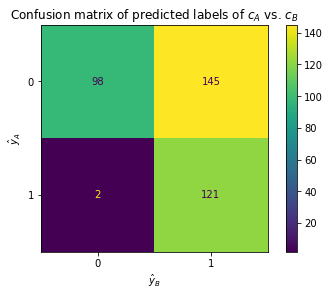

In [9]:
comparer.plot_confusion_matrix(X)

We can see already, that A predicts a lot more often less than 4500 shares than B, reflected in the high number of instances in difference class $(0,1)$. On the contrary, only two instances fall into $(1,0)$.

In [10]:
is_pred_diff = comparer.predict_bin_diff(X)
mclass_diff = comparer.predict_mclass_diff(X)

In [10]:
%%time
masker = shap.maskers.Independent(data=X, max_samples=X.shape[0])
explanations, indices_nonfinite_predictions, explanations_nonfinite = \
    generate_shap_explanations(comparer, X, masker=masker,
                               explanation_types=['indiv', 'indiv_diff', 'mclass_diff'],
                               space_types=['log_odds'])

Exact explainer: 367it [02:11,  2.67it/s]                         
Exact explainer: 367it [01:34,  3.45it/s]                         
Exact explainer: 367it [03:50,  1.52it/s]                         

CPU times: user 26min 13s, sys: 36.1 s, total: 26min 49s
Wall time: 7min 36s


In [11]:
with open('shap-values.pickle', 'wb') as f:
    pickle.dump((explanations, indices_nonfinite_predictions, explanations_nonfinite), f, pickle.HIGHEST_PROTOCOL)

# Global Explanations

In [5]:
X = pd.DataFrame(explanations.data, columns=explanations.feature_names)
is_pred_diff = comparer.predict_bin_diff(X)
mclass_diff = comparer.predict_mclass_diff(X)

## SHAP-based Individual Classifiers' Explanations

Both classifiers have the same most important feature: `temp`. Besides that, they're quite different.
`mnth`, `hum`, `atemp`, `weekday`, `workingday` are of bigger importance to A than to B.
`mnth` is also the feature with the biggest difference of feature importance.
`season`, `weathersit` are of higher importance to B than to A.
Finally, `holiday` has no significant importance to either classifiers.
Therefore I will omit it from further explanations.

Based on this, I can speculate about the following theories:
- Both classifiers are influenced by time of the year: A more by month, B more by season
- Both classifiers are influenced by weather conditions: A more by temperature and humidity, B more by weathersituation
- holiday is not used to make decisions, because workingday is already sufficient
- B depends less on weekday and workingday, possibly indicating a shift of habits

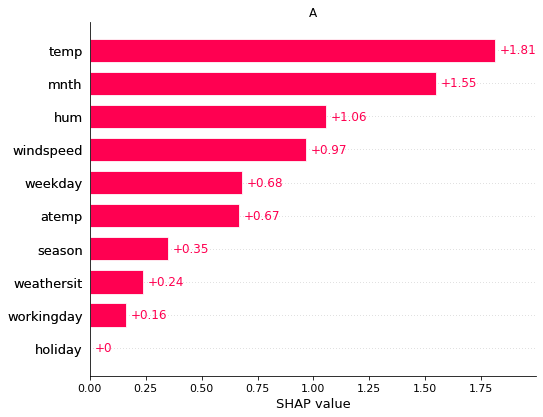

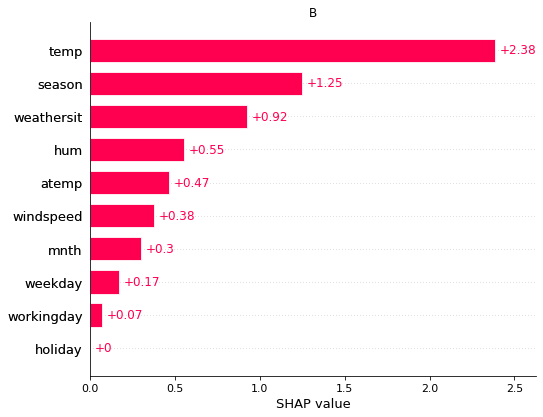

In [25]:
feature_order, feature_importance = calc_feature_order(explanations.indiv.log_odds.A[:, :, 1])
plot_feature_importance_bar(feature_importance, 'A', feature_order)
feature_order, feature_importance = calc_feature_order(explanations.indiv.log_odds.B[:, :, 1])
plot_feature_importance_bar(feature_importance, 'B', feature_order)

In [26]:
feature_order, _ = calc_feature_order(explanations.indiv.log_odds[:, :, 1])

In [27]:
feature_order = feature_order[:9]

In [28]:
def plot_next_feature():
    feature_idx = next(it)
    plot_feature_effects(explanations.indiv.log_odds[:, [feature_idx], 1], color=is_pred_diff)
it = iter(feature_order)

In the SHAP summary plot we can see, that the most important feature `temp`
generally indicates an increase in log odds for high values
and a decrease in log odds for low values.
But the distribution is different:
For A, low feature values indicate a very specific decrease of log odds.
On the contrary, there is a wide range of different SHAP values for B.
This indicates, that there are many different ways low temperature values influences the prediction in B,
but only a few in A.

For A, we can see a stepped effect from low to high feature values with the step at 0.5,
which gradually decreases again at 0.7.
For B, the effect of `temp` gradually increases, starting from 0.3 until it reaches its maximum at 0.5.

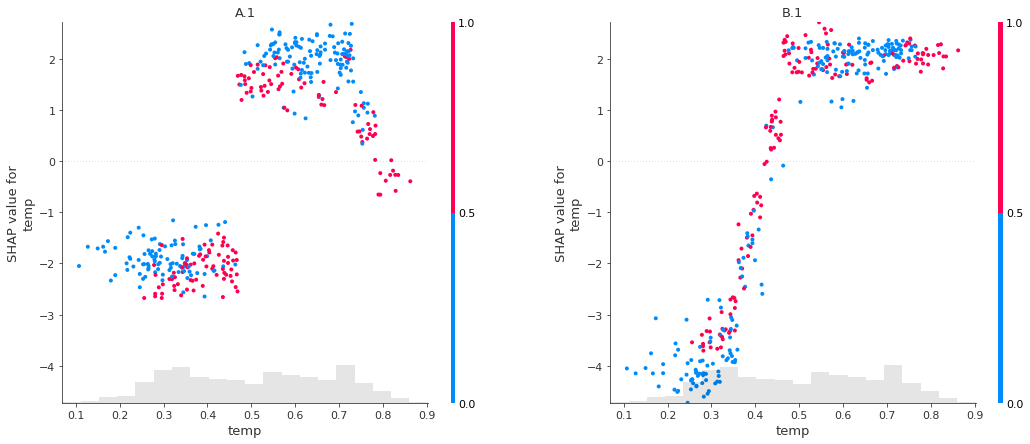

In [29]:
plot_next_feature()

As previously noted in the feature importance section, `mnth` is much more important
to A than to B. Higher feature values increase the log odds prediction to a varying extent in A,
whereas in B they nearly have no influence. Lower feature values decrease the log odds prediction
in A, but there are instances in B where they either increase or decrease the log odds prediction.

According to the feature effects plots, the first four months have a negative effect while the
higher months have a positive effect on the outcome of A.
For B, only the first two months have a negative effect and especially month 3 has a positive effect.

Similarly to the effects plots of `temp`, we see
a vertical separation of instances classified differently and equally, which means,
interaction effects are present.

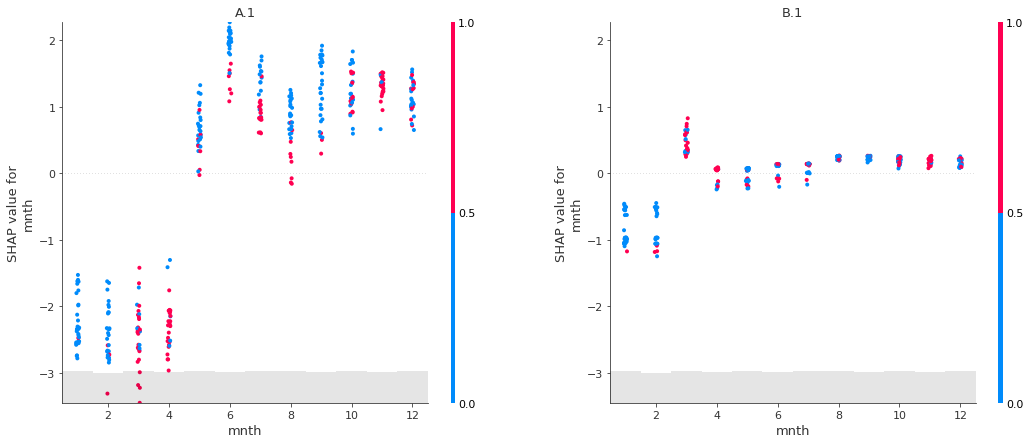

In [30]:
plot_next_feature()

For both classifiers, high `hum` values decrease the log odds outcome to a similar extent.
But the lower values are different. In B, they flat out between 0.5 and 1, but in A,
they continue to increase for lower values. This means, that in B, there are not many ways
how low values of `hum` can influence the outcome, but there are many for A.

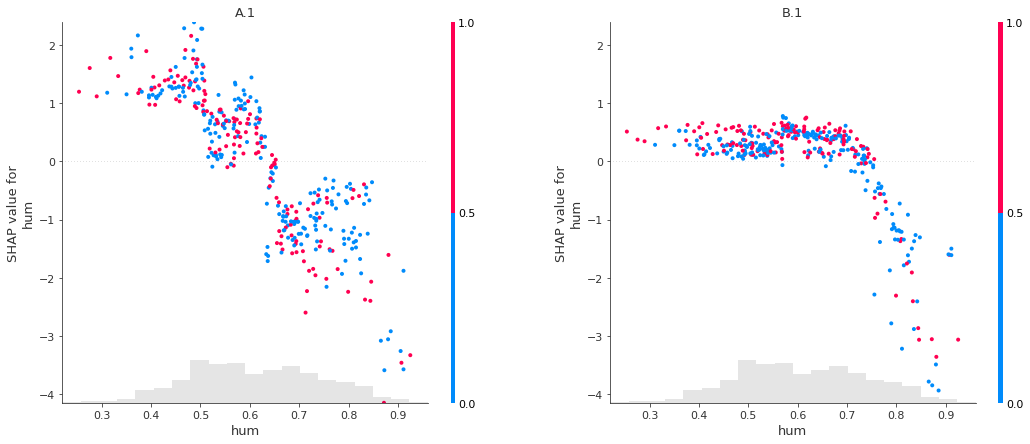

In [31]:
plot_next_feature()

`season` 1 (winter) has much bigger negative influence on model B than on A, with a broader
range of values. To instances classified differently in this group the effect is smaller,
originating from interaction effects with other features.
The other seasons have higher increasing effect to B than A.

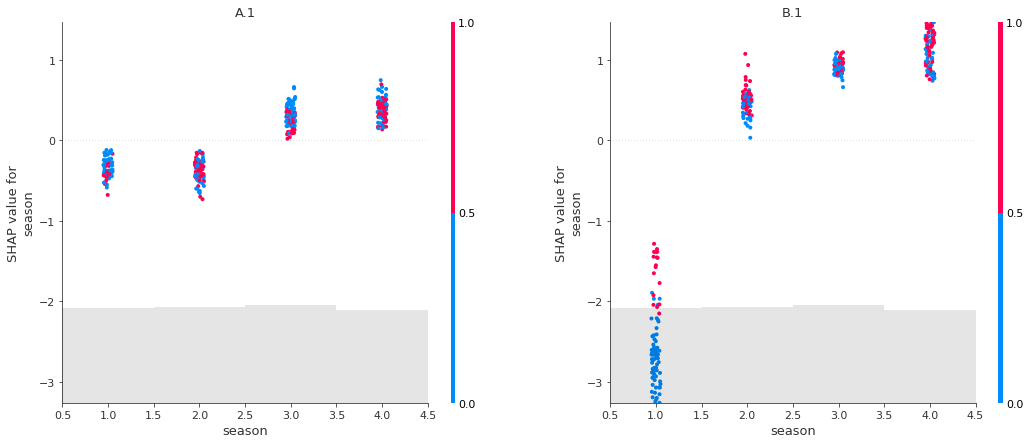

In [32]:
plot_next_feature()

Windspeed has higher and more pronounced influence on model A than B, with low feature
values increasing and high feature values decreasing the outcome.

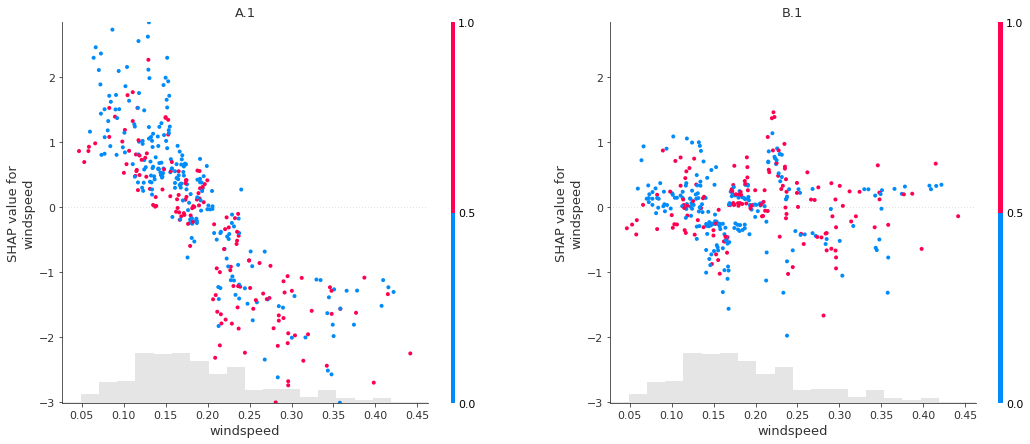

In [33]:
plot_next_feature()

For B, high values of `weathersit` (snow and rain) have bigger negative influence and low values
(clear to mist) have bigger positive influence than for A. It is possibly a better predictor
in the newer model than `windspeed` and `hum` combined.

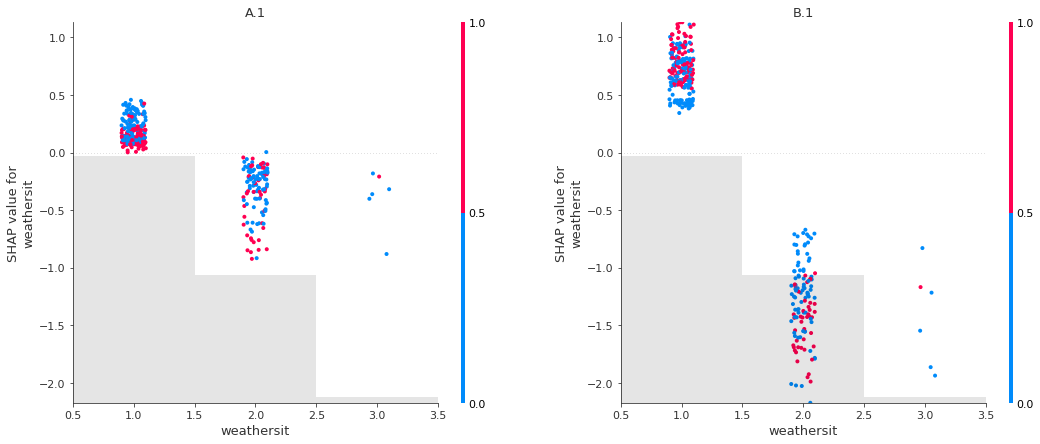

In [34]:
plot_next_feature()

High feature values of `atemp` influence the models differently:
For A, it has quite diverse effects ranging from -3 to +2, whereas for B,
it just indicates a small positive influence.

The effects look similar, except for values above 0.7,
where all instances are classified differently.
Here we observe a negative influence on A but positive influence on B.

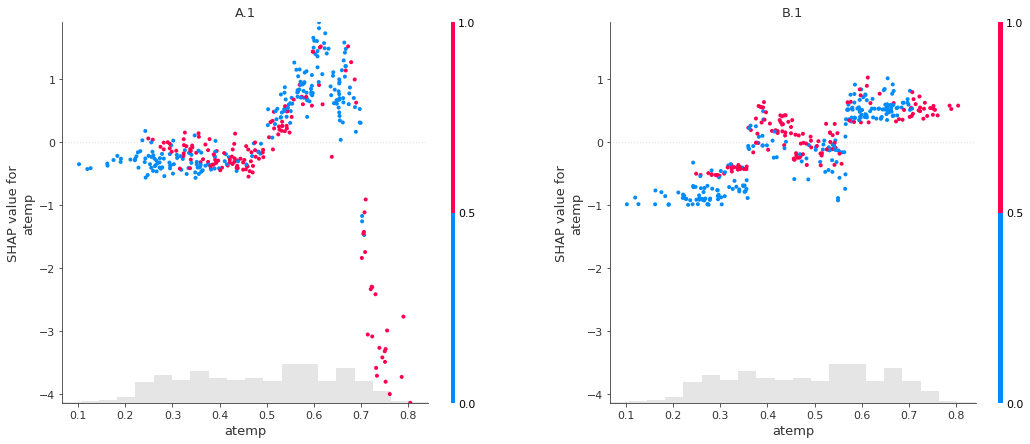

In [35]:
plot_next_feature()

Even though the influences of `weekday` on model B are small and decreasing from low (Sunday)
to high (Saturday) values,
they are the opposite of those on model A.

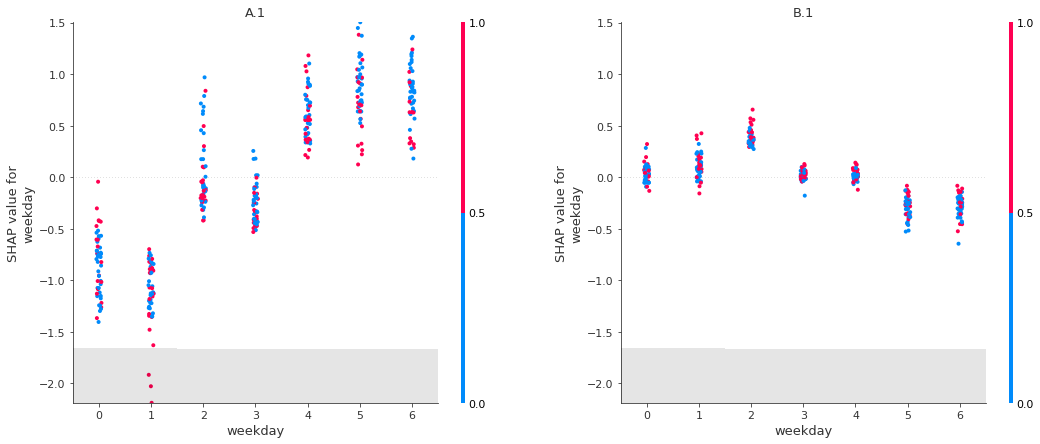

In [36]:
plot_next_feature()

`workingday` is considered more important by A, which also shows a clearer separation
of low and high values, low values (weekend or holiday) having positive influence on the outcome.
To B, it seems to be random noise with no special influence of low or high values,
and no characteristics of instances classified differently.
I assume that model A differentiates
more between work and leisure time, with more people using bicycles in their leisure time
and/or in the second half of the week, reasons not present in model B.

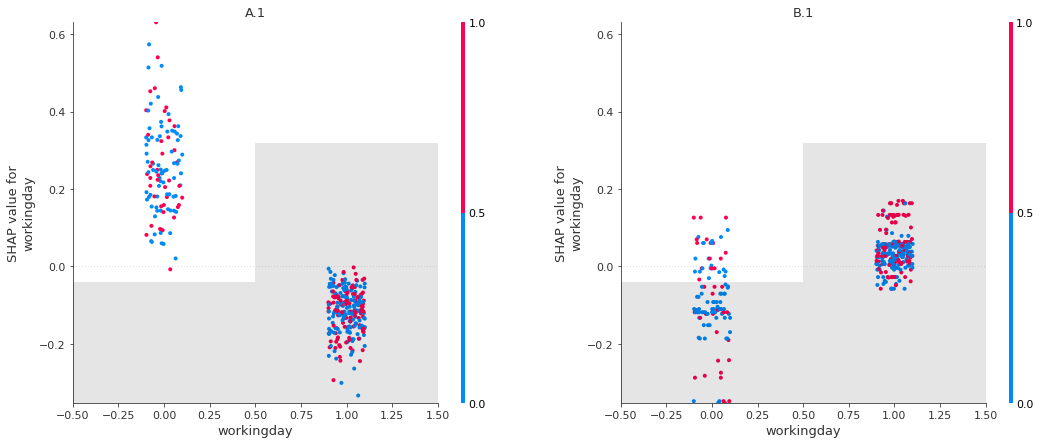

In [37]:
plot_next_feature()

## SHAP-based Difference Classifier Explanations

In the figure below we can see the feature importances per class.
`temp` is the most important feature overall. `holiday` has zero importance, so I will not analyze its effects.

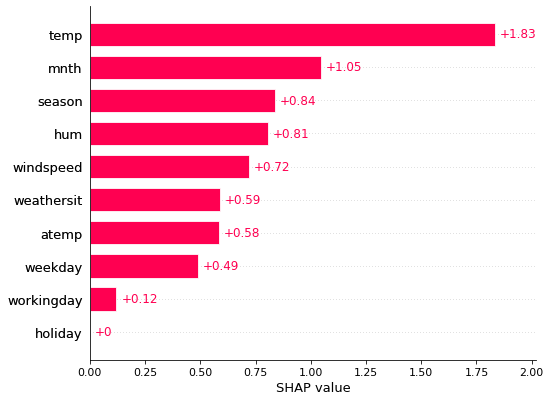

In [5]:
feature_order, feature_importances = calc_feature_order(explanations.mclass_diff.log_odds)
plot_feature_importance_bar(feature_importances)

In [6]:
global_feature_order = feature_order
feature_order = feature_order[:-1]

In [9]:
global_data = pd.DataFrame(explanations.data, columns=explanations.feature_names)
global_data.iloc[:, global_feature_order].describe()

temp        mnth      season         hum   windspeed  weathersit  \
count  366.000000  366.000000  366.000000  366.000000  366.000000  366.000000   
mean     0.504081    6.513661    2.494536    0.612166    0.189572    1.368852   
std      0.176112    3.455958    1.112185    0.134206    0.078194    0.516057   
min      0.107500    1.000000    1.000000    0.254167    0.046650    1.000000   
25%      0.347708    4.000000    2.000000    0.508125    0.133721    1.000000   
50%      0.514167    7.000000    2.500000    0.611875    0.174750    1.000000   
75%      0.653959    9.750000    3.000000    0.711146    0.231196    2.000000   
max      0.861667   12.000000    4.000000    0.925000    0.441563    3.000000   

            atemp     weekday  workingday     holiday  
count  366.000000  366.000000  366.000000  366.000000  
mean     0.481852    2.986339    0.683060    0.030055  
std      0.156756    2.006108    0.465921    0.170971  
min      0.101658    0.000000    0.000000    0.000000  
25%      0.350685    1.000000    0.000000    0.000000  
50%      0.497779    3.000000    1.000000    0.000000  
75%      0.607646    5.000000    1.000000    0.000000  
max      0.804913    6.000000    1.000000    1.000000

In [42]:
global_data['workingday'].value_counts()

1.0    250
0.0    116
Name: workingday, dtype: int64

In [43]:
global_data['weathersit'].value_counts()

1.0    237
2.0    123
3.0      6
Name: weathersit, dtype: int64

Considering that there are only four classes and all have importance, I will stick to the original ordering.

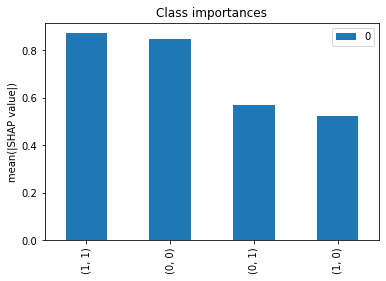

In [44]:
class_order, class_importances = calc_class_order(explanations.mclass_diff.log_odds)
plot_class_importances(class_importances, class_order, explanations.mclass_diff.output_names)

In [45]:
def plot_next_feature():
    feature_idx = next(it)
    plot_feature_effects(explanations.mclass_diff.log_odds[:, [feature_idx]], color=is_pred_diff)
it = iter(feature_order)

For instances with low feature values ($temp<0.3$), this feature increases the outcome for class $(0,0)$ extremely,
for most of them by more than 4. Until 0.5, there is a drop in log odds of this class
and first an increase of $(1,0)$, then an even higher increase of $(0,1)$.
Many instances classified differently fall into this range.
Above 0.5, there is a sudden increase of $(1,1)$, which gets lower
at 0.7 while getting higher for $(0,1)$ again, also containing
many instances classified differently.

Even though this is the feature of highest importance for the differences,
its explanation does not cover all instances. Especially for those with
$0.5<temp<0.7$, this feature cannot be the reason for them being classified
differently.

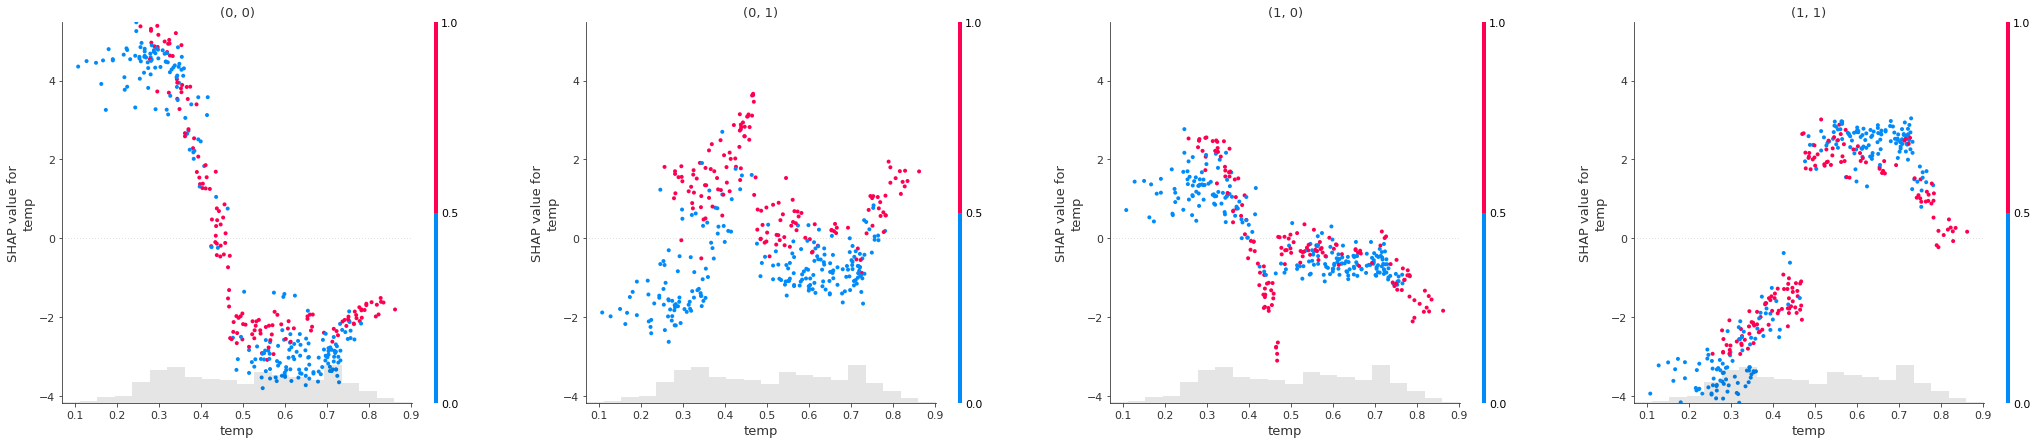

In [46]:
plot_next_feature()

Starting with the first two values of `mnth`, this feature has an increasing effect on the outcome of $(0,0)$,
with nearly no instances classified differently.
For months 3 and 4 it primarily increases the odds of $(0,1)$.
Continuing with higher values, it increases the odds to a varying degree of $(1,1)$ and $(1,0)$ to a lower extent.

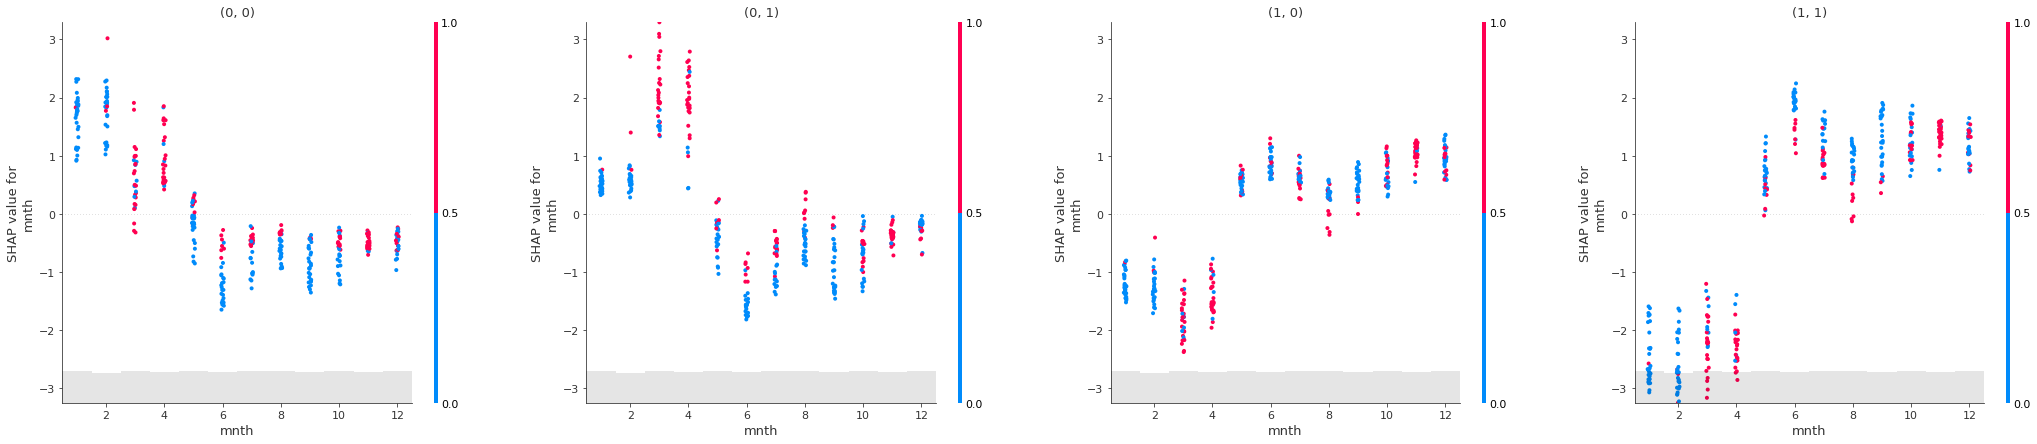

In [47]:
plot_next_feature()

For instances with low `season` values (winter) the feature has an increasing effect on the odds of $(0,0)$,
and to a lower extent of $(1,0)$. But for those that are classified differently the increasing effect
is on the lower side and the decreasing effect on $(0,1)$ is smaller too, suggesting interaction effects
with other features. For instances of spring,
summer and fall the feature has a low increasing effect on the odds of $(1,1)$ and $(0,1)$.

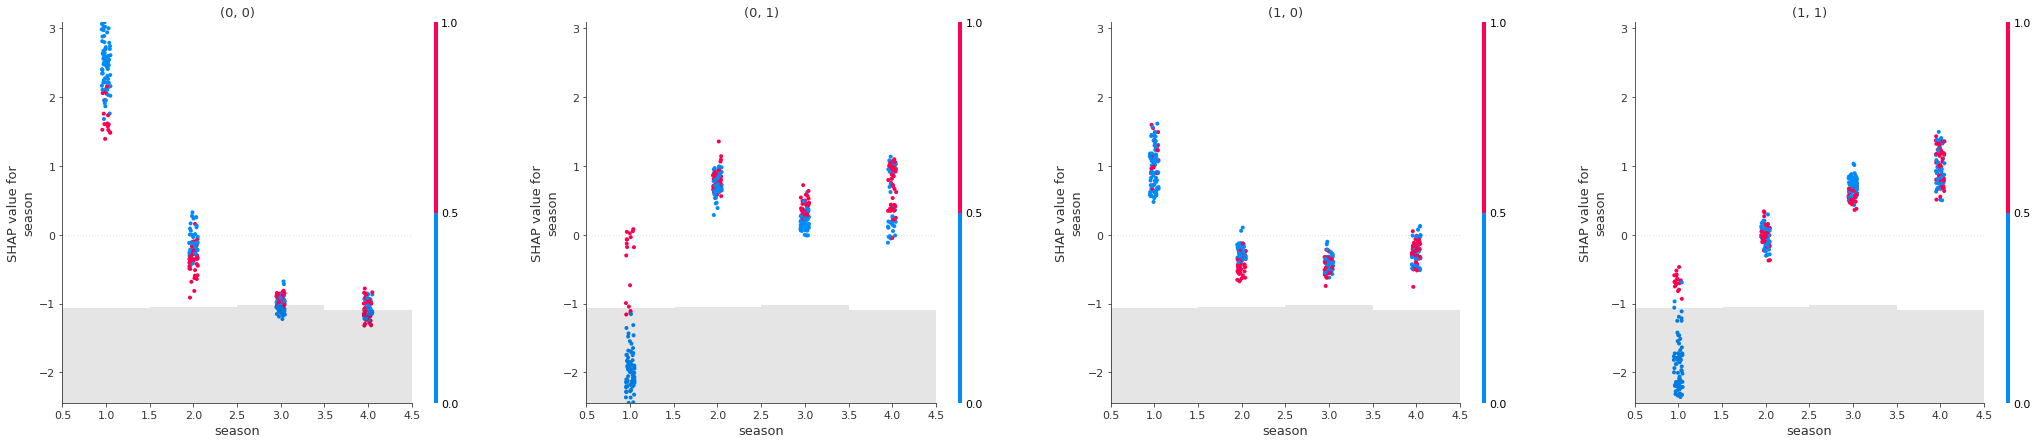

In [48]:
plot_next_feature()

Generally, for this feature there is positive correlation
with its increase in outcome of $(0,0)$ and negative correlation with its
increase in outcome of $(1,1)$.

Nevertheless, for instances with values around 0.7 there is a slight increase
in the outcome of $(0,1)$ and for instances with values below 0.5 and above
0.75 there is a slight increase in the outcome of $(1,0)$.

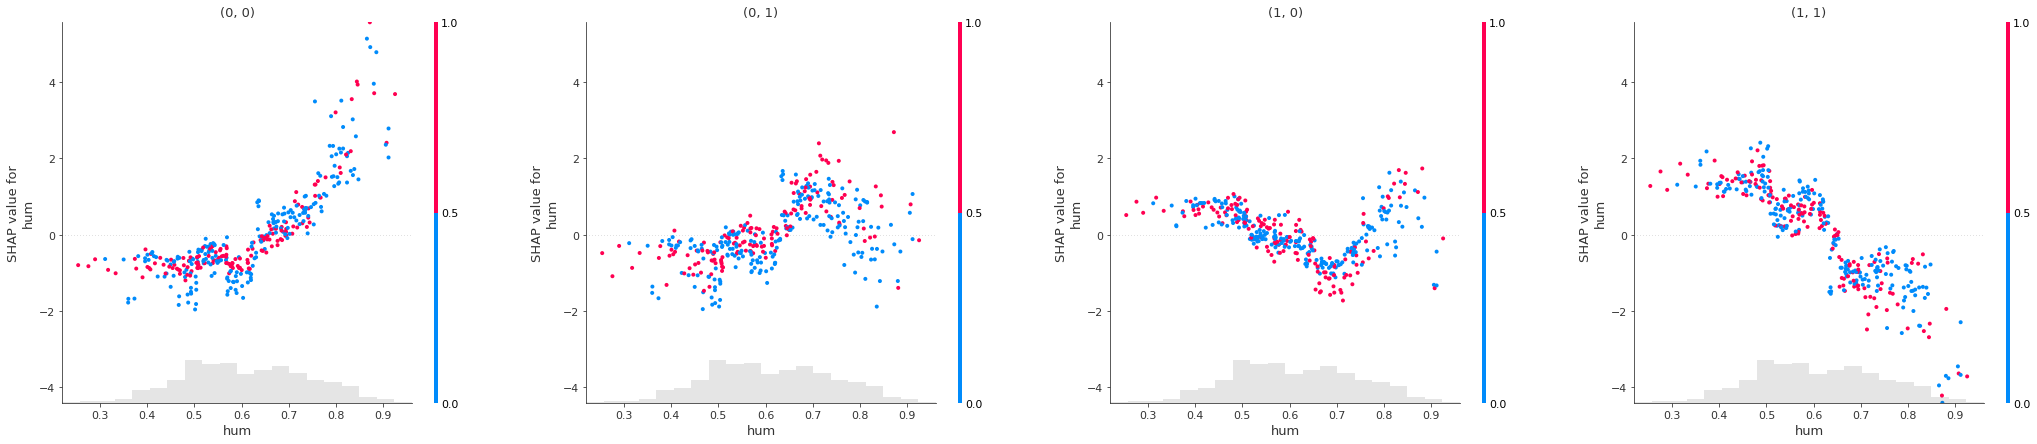

In [49]:
plot_next_feature()

For `windspeed`, there is a positive correlation with the effect on $(0,0)$ and $(0,1)$,
and a negative correlation with the effect on $(1,1)$ and $(1,0)$ to a lower extent.

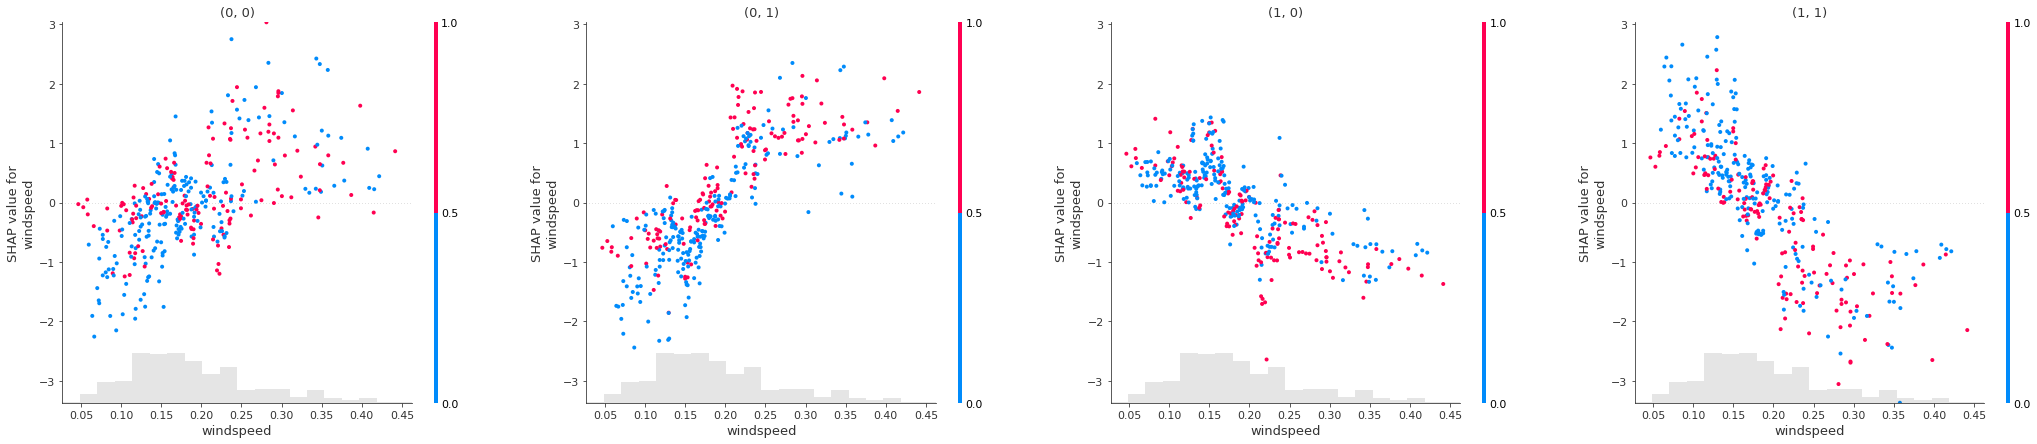

In [50]:
plot_next_feature()

For instances with `weathersit` 1 (clear) the feature has a slightly 
increasing effect on $(1,1)$. For instances with values 2 or 3 (bad weather
conditions) it has an increasing effect on $(0,0)$ and to a lower extent
on $(1,0)$.

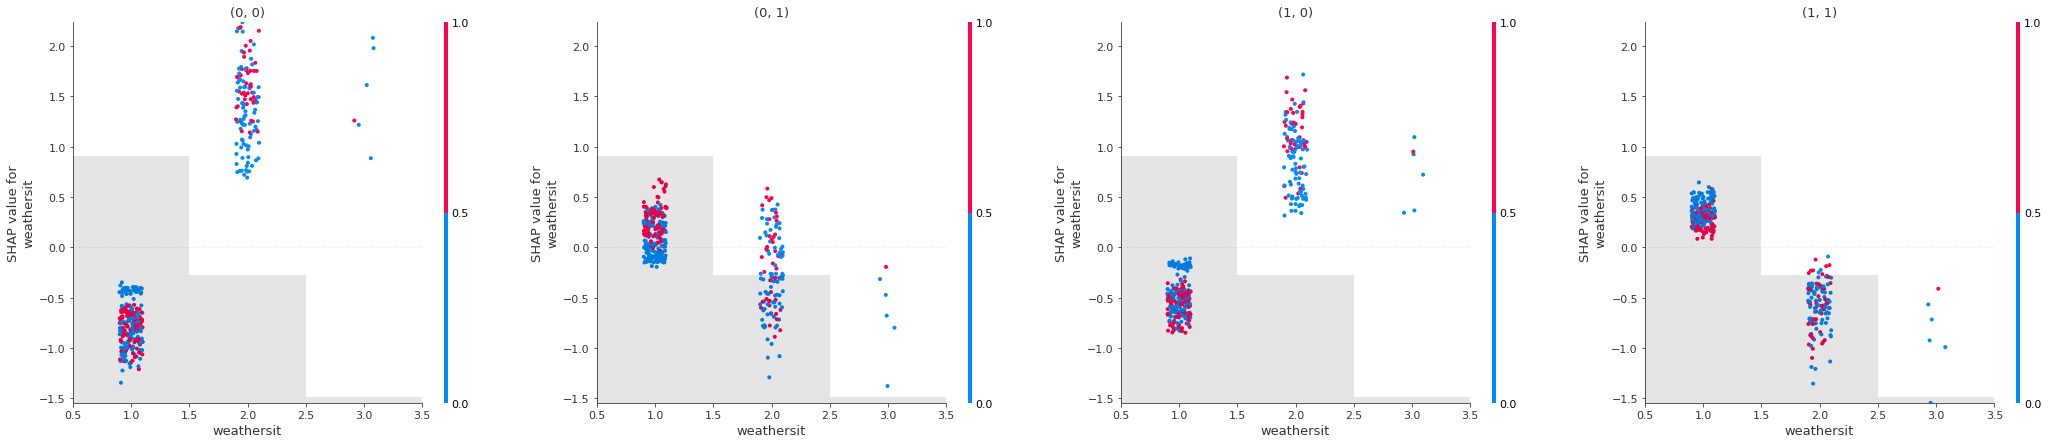

In [51]:
plot_next_feature()

For instances with low `atemp` values this feature has a slightly increasing
effect on $(0,0)$. Up to 0.5, its effect decreases while the effect on $(0,1)$
increases slightly. Up to 0.7, the effect on $(0,1)$ decreases again
but increases on $(1,1)$, with fewer instances classified differently in this range.
Above, the effect on $(1,1)$ drops to negative values while it increases
dramatically on $(0,1)$, where all instances are classified differently.
`atemp` is probably the main reason for them being classified differently.

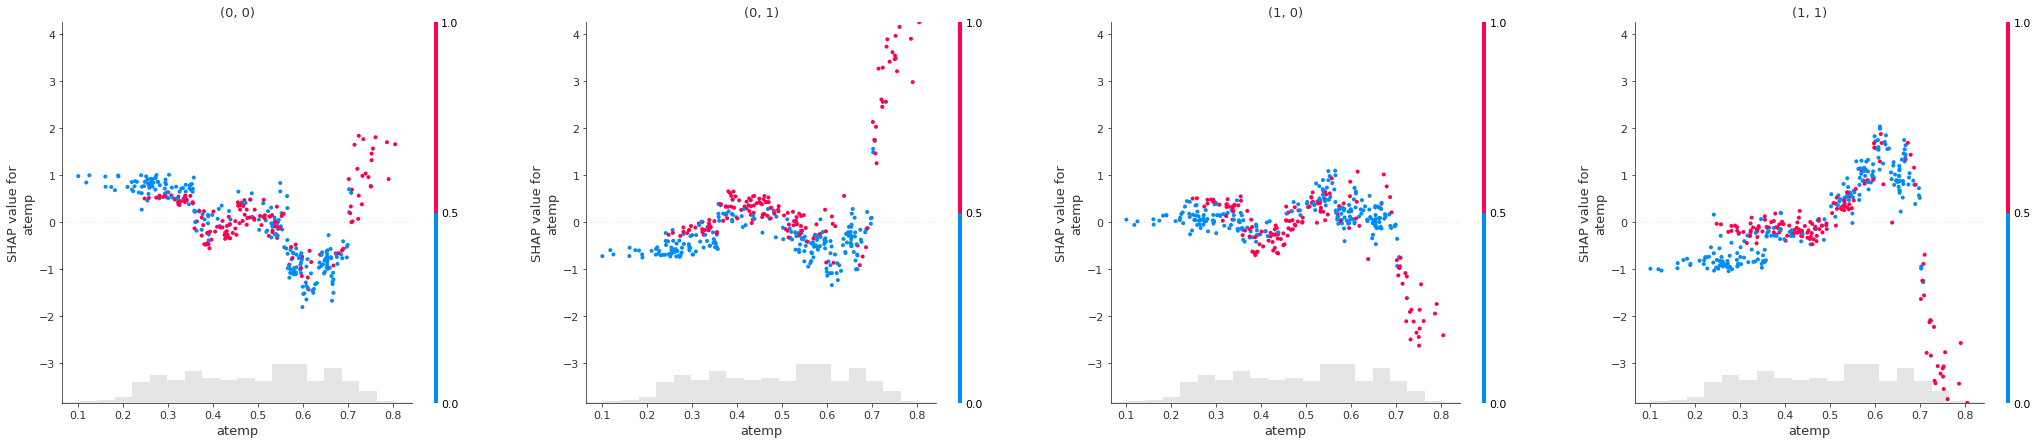

In [52]:
plot_next_feature()

For instances with low `weekday` values (Sunday and Monday) the feature has an increasing effect
on the odds of $(0,1)$ and to a lower extent of $(0,0)$,
while for those with high feature values (Friday, Saturday and Sunday) it has an increasing effect for the odds
of $(1,0)$ and $(1,1)$.

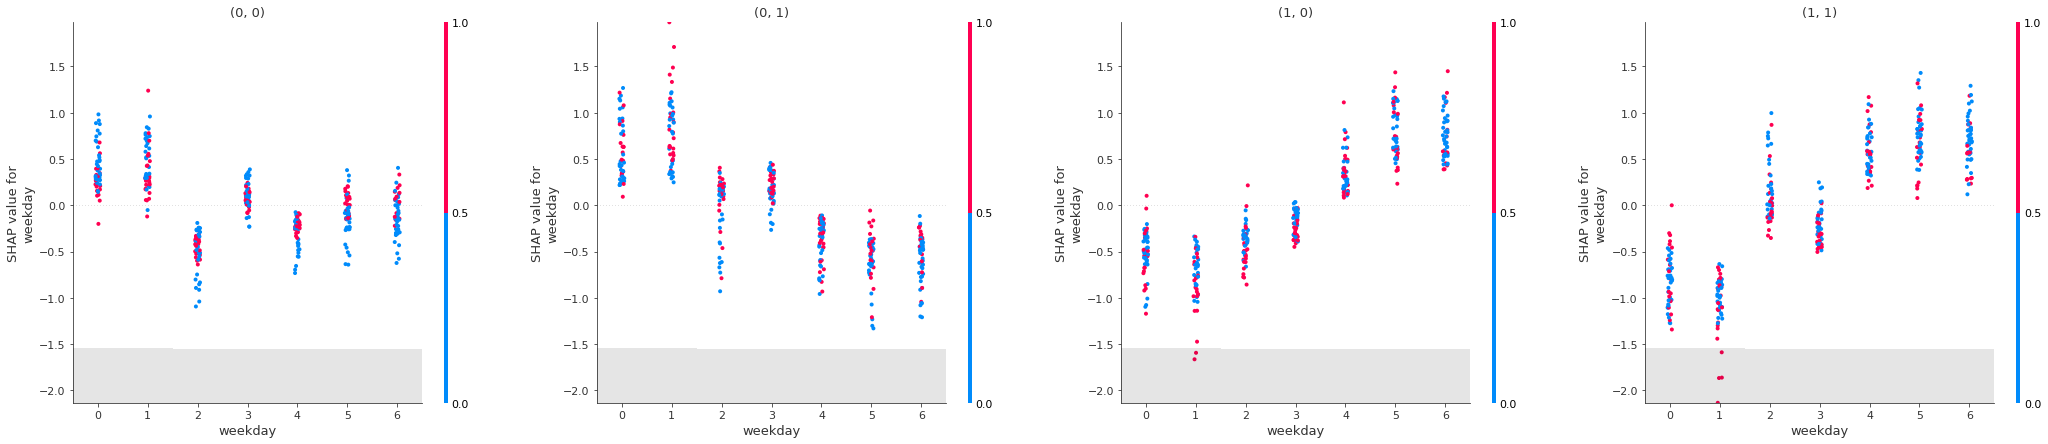

In [53]:
plot_next_feature()

For workingday we can see only a slight linear effect with big variance that tends towards $(1,0)$ and $(1,1)$ for value 0, and towards $(0,0)$ and $(0,1)$ for value 1.

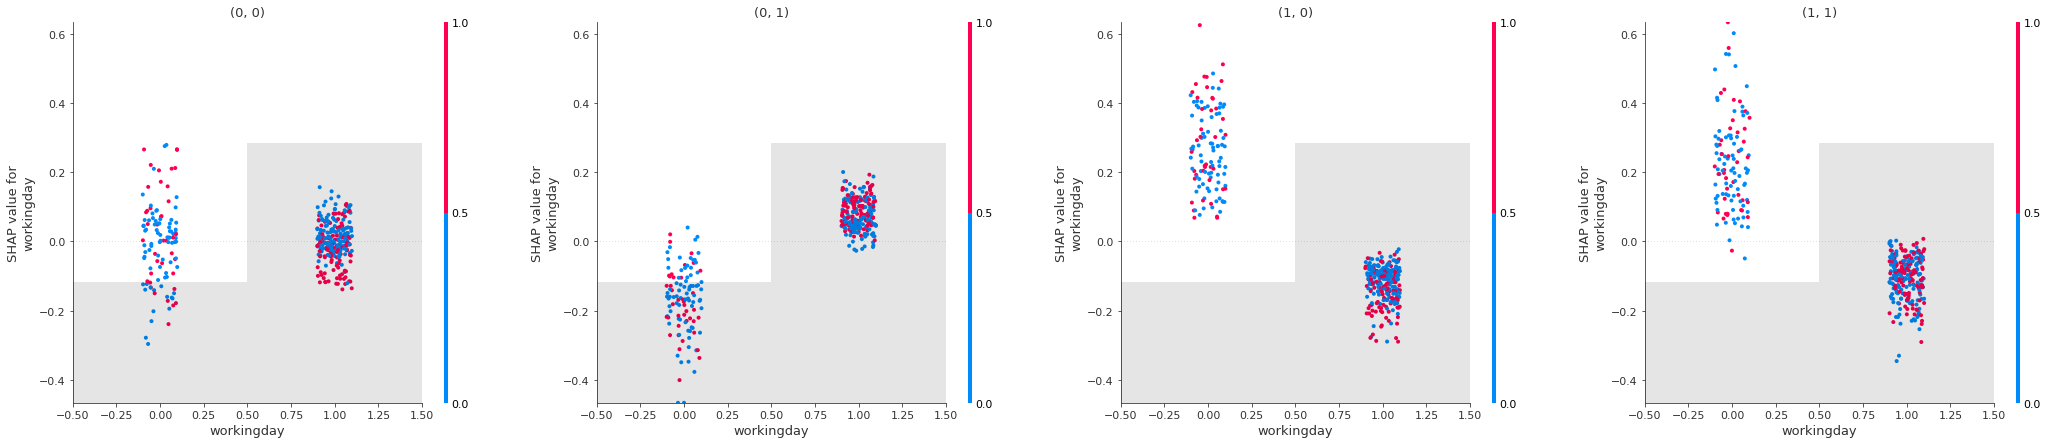

In [54]:
plot_next_feature()

# Local Explanations

## Clustering of Class $(0,1)$ SHAP Values

In [94]:
clustering = make_clustering(comparer, explanations.mclass_diff.log_odds, '(0, 1)', '(0, 0)', '(1, 1)')

node #730 (level 0)
(0, 1)    145
(1, 1)    121
(0, 0)     98
(1, 0)      2
dtype: int64


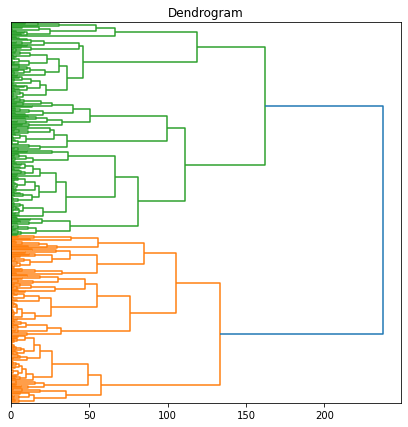

In [8]:
clustering.plot_dendrogram()

### Cluster 1

In [75]:
clustering.go_down()

node #728 (level 1)
(0, 0)    91
(0, 1)    66
(1, 1)     2
(1, 0)     2
dtype: int64


Cluster characteristics:
- $temp < 0.47$
- $atemp < 0.47$

Diff class characteristics:
- $0.25 < temp < 0.47$
- $1 ≤ weathersit ≤ 2$
- $0.24 < atemp < 0.47$

In [10]:
for feature in global_feature_order:
    print(comparer.feature_names[feature])
    display(clustering.describe_feature(feature))

temp


global   local-all  local-diff
count  366.000000  161.000000   66.000000
mean     0.504081    0.332869    0.380832
std      0.176112    0.078053    0.060349
min      0.107500    0.107500    0.255833
25%      0.347708    0.280833    0.334375
50%      0.514167    0.337500    0.386250
75%      0.653959    0.393333    0.436875
max      0.861667    0.468333    0.468333

mnth


global   local-all  local-diff
count  366.000000  161.000000   66.000000
mean     6.513661    6.093168    8.166667
std      3.455958    4.591842    3.817302
min      1.000000    1.000000    1.000000
25%      4.000000    2.000000    4.000000
50%      7.000000    4.000000   11.000000
75%      9.750000   11.000000   11.000000
max     12.000000   12.000000   12.000000

season


global   local-all  local-diff
count  366.000000  161.000000   66.000000
mean     2.494536    2.217391    3.136364
std      1.112185    1.381556    1.148730
min      1.000000    1.000000    1.000000
25%      2.000000    1.000000    2.000000
50%      2.500000    1.000000    4.000000
75%      3.000000    4.000000    4.000000
max      4.000000    4.000000    4.000000

hum


global   local-all  local-diff
count  366.000000  161.000000   66.000000
mean     0.612166    0.584715    0.544962
std      0.134206    0.143415    0.119136
min      0.254167    0.254167    0.254167
25%      0.508125    0.485833    0.477197
50%      0.611875    0.555652    0.543125
75%      0.711146    0.687917    0.624896
max      0.925000    0.911250    0.907083

windspeed


global   local-all  local-diff
count  366.000000  161.000000   66.000000
mean     0.189572    0.204457    0.207459
std      0.078194    0.086108    0.087999
min      0.046650    0.046650    0.046650
25%      0.133721    0.146142    0.149884
50%      0.174750    0.187192    0.195269
75%      0.231196    0.249375    0.265085
max      0.441563    0.421642    0.414800

weathersit


global   local-all  local-diff
count  366.000000  161.000000   66.000000
mean     1.368852    1.422360    1.212121
std      0.516057    0.531975    0.411943
min      1.000000    1.000000    1.000000
25%      1.000000    1.000000    1.000000
50%      1.000000    1.000000    1.000000
75%      2.000000    2.000000    1.000000
max      3.000000    3.000000    2.000000

atemp


global   local-all  local-diff
count  366.000000  161.000000   66.000000
mean     0.481852    0.330918    0.377396
std      0.156756    0.077895    0.058420
min      0.101658    0.101658    0.248742
25%      0.350685    0.274621    0.337392
50%      0.497779    0.338363    0.383209
75%      0.607646    0.389508    0.430375
max      0.804913    0.461483    0.461483

weekday


global   local-all  local-diff
count  366.000000  161.000000   66.000000
mean     2.986339    2.962733    2.984848
std      2.006108    2.042940    1.885103
min      0.000000    0.000000    0.000000
25%      1.000000    1.000000    1.250000
50%      3.000000    3.000000    3.000000
75%      5.000000    5.000000    5.000000
max      6.000000    6.000000    6.000000

workingday


global   local-all  local-diff
count  366.000000  161.000000   66.000000
mean     0.683060    0.664596    0.757576
std      0.465921    0.473605    0.431834
min      0.000000    0.000000    0.000000
25%      0.000000    0.000000    1.000000
50%      1.000000    1.000000    1.000000
75%      1.000000    1.000000    1.000000
max      1.000000    1.000000    1.000000

holiday


global   local-all  local-diff
count  366.000000  161.000000   66.000000
mean     0.030055    0.037267    0.030303
std      0.170971    0.190007    0.172733
min      0.000000    0.000000    0.000000
25%      0.000000    0.000000    0.000000
50%      0.000000    0.000000    0.000000
75%      0.000000    0.000000    0.000000
max      1.000000    1.000000    1.000000

At the upper boundary of temp there is a drop of the positive influence towards $(0,1)$, instead the influence towards $(1,1)$ increases by ~4.

In [11]:
clustering.test(temp=0.47)

before  after
(0, 1)    66.0     33
(1, 1)     NaN     33

Influence towards $(0,1)$ has a local high around 0.4, but decreases into the negative between 0.5 and 0.6, yet the effect towards $(1,1)$ increases to a global high.

In [12]:
clustering.test(atemp=0.6)

before  after
(0, 1)    66.0     52
(1, 1)     NaN     14

Yet this big cluster yields only a single explanation.

In [13]:
clustering.test(temp=.47, atemp=0.6)

before  after
(0, 1)    66.0     25
(1, 1)     NaN     41

In [76]:
clustering.go_down()

node #718 (level 2)
(0, 0)    65
dtype: int64


In [77]:
clustering.get_next()

node #728 (level 1)
(0, 0)    91
(0, 1)    66
(1, 1)     2
(1, 0)     2
dtype: int64
node #725 (level 2)
(0, 1)    66
(0, 0)    26
(1, 1)     2
(1, 0)     2
dtype: int64


Cluster characteristics:
- $0.24 < temp < 0.47$
- $0.24 < atemp < 0.47$

Diff class characteristics:
- $0.25 < temp$
- $weathersit ≤ 2$ (not relevant)

In [16]:
for feature in global_feature_order:
    print(comparer.feature_names[feature])
    display(clustering.describe_feature(feature))

temp


global  local-all  local-diff
count  366.000000  96.000000   66.000000
mean     0.504081   0.375741    0.380832
std      0.176112   0.057190    0.060349
min      0.107500   0.245833    0.255833
25%      0.347708   0.328958    0.334375
50%      0.514167   0.378750    0.386250
75%      0.653959   0.424375    0.436875
max      0.861667   0.468333    0.468333

mnth


global  local-all  local-diff
count  366.000000  96.000000   66.000000
mean     6.513661   7.927083    8.166667
std      3.455958   4.063301    3.817302
min      1.000000   1.000000    1.000000
25%      4.000000   4.000000    4.000000
50%      7.000000  10.000000   11.000000
75%      9.750000  11.000000   11.000000
max     12.000000  12.000000   12.000000

season


global  local-all  local-diff
count  366.000000  96.000000   66.000000
mean     2.494536   3.041667    3.136364
std      1.112185   1.230461    1.148730
min      1.000000   1.000000    1.000000
25%      2.000000   2.000000    2.000000
50%      2.500000   4.000000    4.000000
75%      3.000000   4.000000    4.000000
max      4.000000   4.000000    4.000000

hum


global  local-all  local-diff
count  366.000000  96.000000   66.000000
mean     0.612166   0.592907    0.544962
std      0.134206   0.141308    0.119136
min      0.254167   0.254167    0.254167
25%      0.508125   0.493438    0.477197
50%      0.611875   0.568958    0.543125
75%      0.711146   0.686875    0.624896
max      0.925000   0.911250    0.907083

windspeed


global  local-all  local-diff
count  366.000000  96.000000   66.000000
mean     0.189572   0.198787    0.207459
std      0.078194   0.084141    0.087999
min      0.046650   0.046650    0.046650
25%      0.133721   0.140388    0.149884
50%      0.174750   0.181909    0.195269
75%      0.231196   0.249377    0.265085
max      0.441563   0.414800    0.414800

weathersit


global  local-all  local-diff
count  366.000000  96.000000   66.000000
mean     1.368852   1.416667    1.212121
std      0.516057   0.516398    0.411943
min      1.000000   1.000000    1.000000
25%      1.000000   1.000000    1.000000
50%      1.000000   1.000000    1.000000
75%      2.000000   2.000000    1.000000
max      3.000000   3.000000    2.000000

atemp


global  local-all  local-diff
count  366.000000  96.000000   66.000000
mean     0.481852   0.373585    0.377396
std      0.156756   0.055314    0.058420
min      0.101658   0.248742    0.248742
25%      0.350685   0.333797    0.337392
50%      0.497779   0.379723    0.383209
75%      0.607646   0.420287    0.430375
max      0.804913   0.461483    0.461483

weekday


global  local-all  local-diff
count  366.000000  96.000000   66.000000
mean     2.986339   3.062500    2.984848
std      2.006108   1.999013    1.885103
min      0.000000   0.000000    0.000000
25%      1.000000   1.000000    1.250000
50%      3.000000   3.000000    3.000000
75%      5.000000   5.000000    5.000000
max      6.000000   6.000000    6.000000

workingday


global  local-all  local-diff
count  366.000000  96.000000   66.000000
mean     0.683060   0.697917    0.757576
std      0.465921   0.461571    0.431834
min      0.000000   0.000000    0.000000
25%      0.000000   0.000000    1.000000
50%      1.000000   1.000000    1.000000
75%      1.000000   1.000000    1.000000
max      1.000000   1.000000    1.000000

holiday


global  local-all  local-diff
count  366.000000  96.000000   66.000000
mean     0.030055   0.020833    0.030303
std      0.170971   0.143576    0.172733
min      0.000000   0.000000    0.000000
25%      0.000000   0.000000    0.000000
50%      0.000000   0.000000    0.000000
75%      0.000000   0.000000    0.000000
max      1.000000   1.000000    1.000000

In [17]:
clustering.test(temp=.24)

before  after
(0, 0)     NaN     15
(0, 1)    66.0     51

In [18]:
clustering.test(atemp=.24)

before  after
(0, 0)     NaN      2
(0, 1)    66.0     64

In [19]:
clustering.test(temp=0.24, atemp=.24)

before  after
(0, 0)     NaN     17
(0, 1)    66.0     49

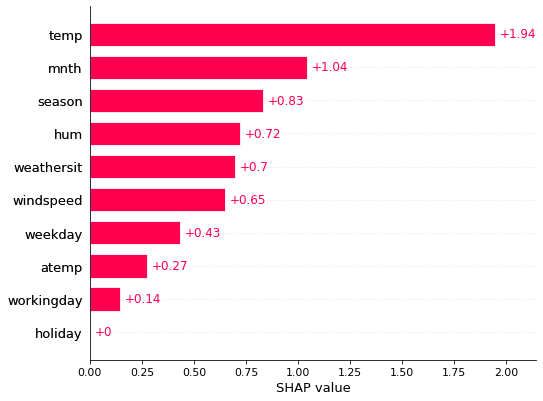

In [20]:
feature_order, feature_importances = calc_feature_order(clustering.shap_values[:, :, clustering.classes])
plot_feature_importance_bar(feature_importances)

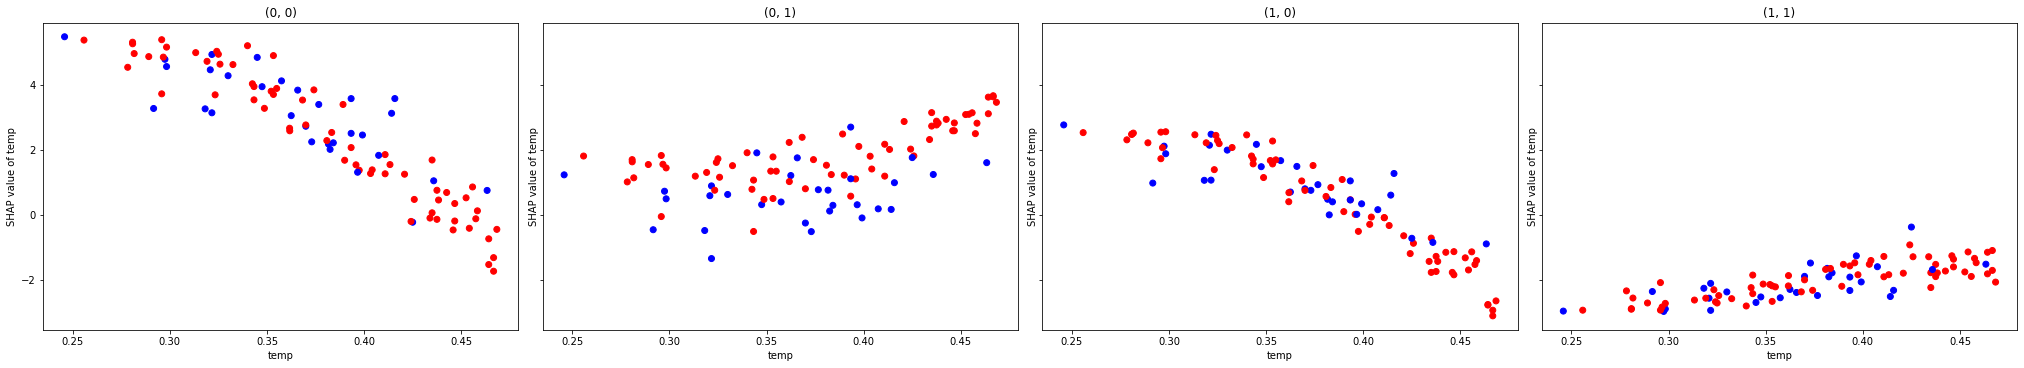

In [21]:
clustering.plot_feature('temp')

In [22]:
clustering.test(temp=0.25)

before  after
(0, 0)     NaN     15
(0, 1)    66.0     51

In [23]:
clustering.test(temp=0.46)

before  after
(0, 1)      66     66

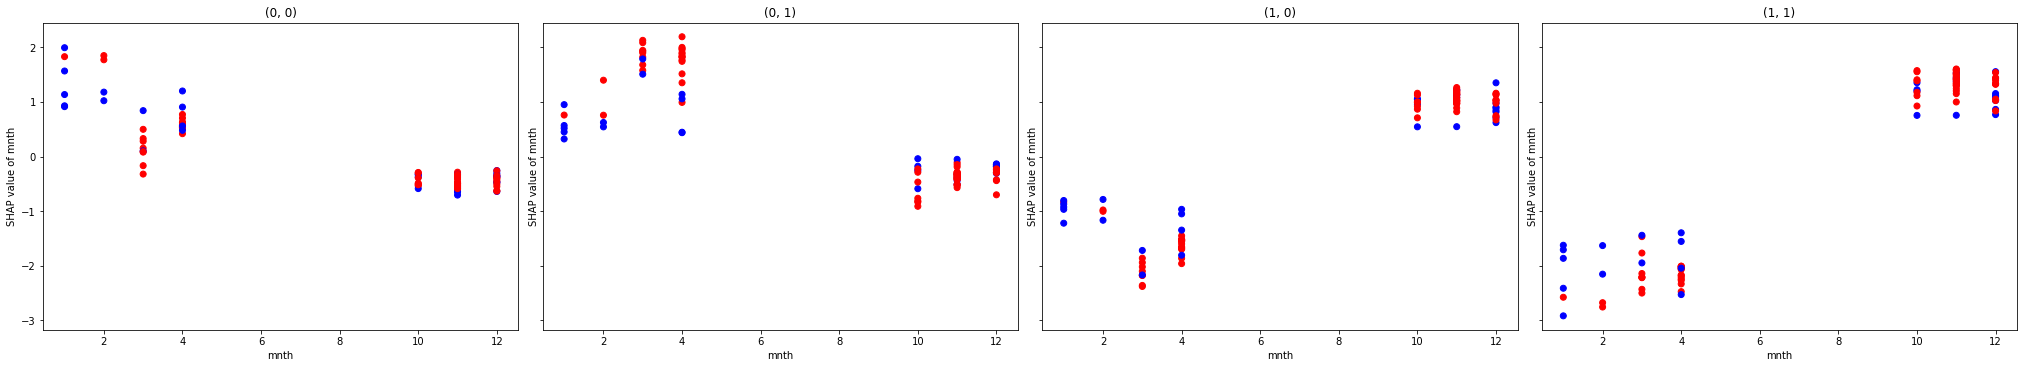

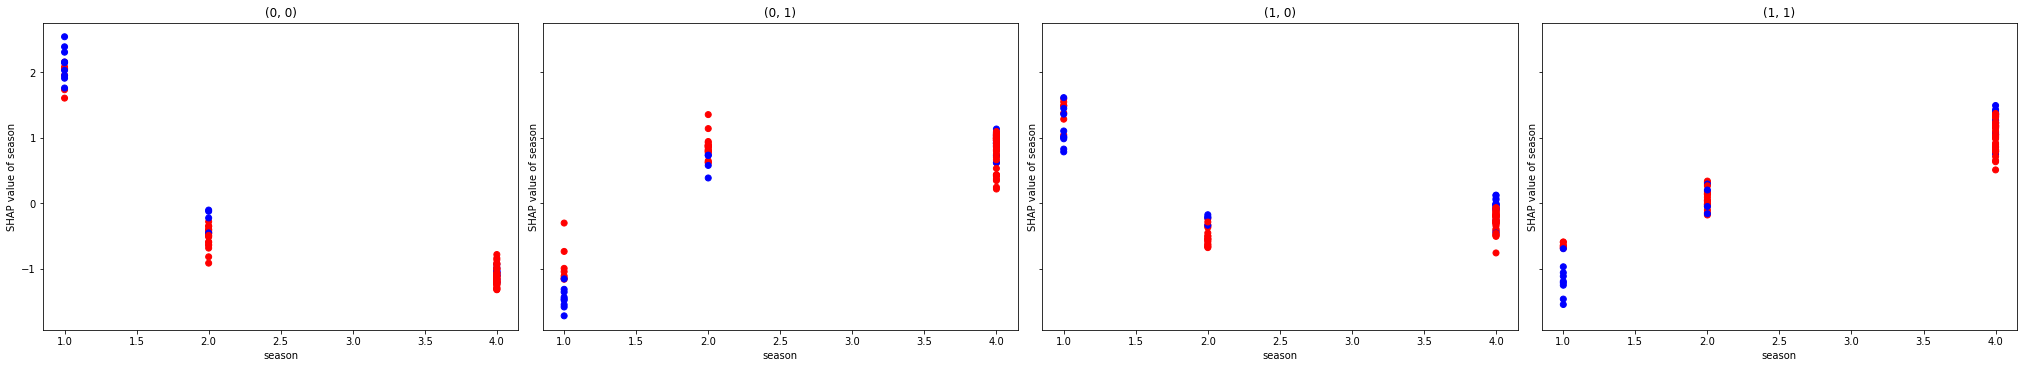

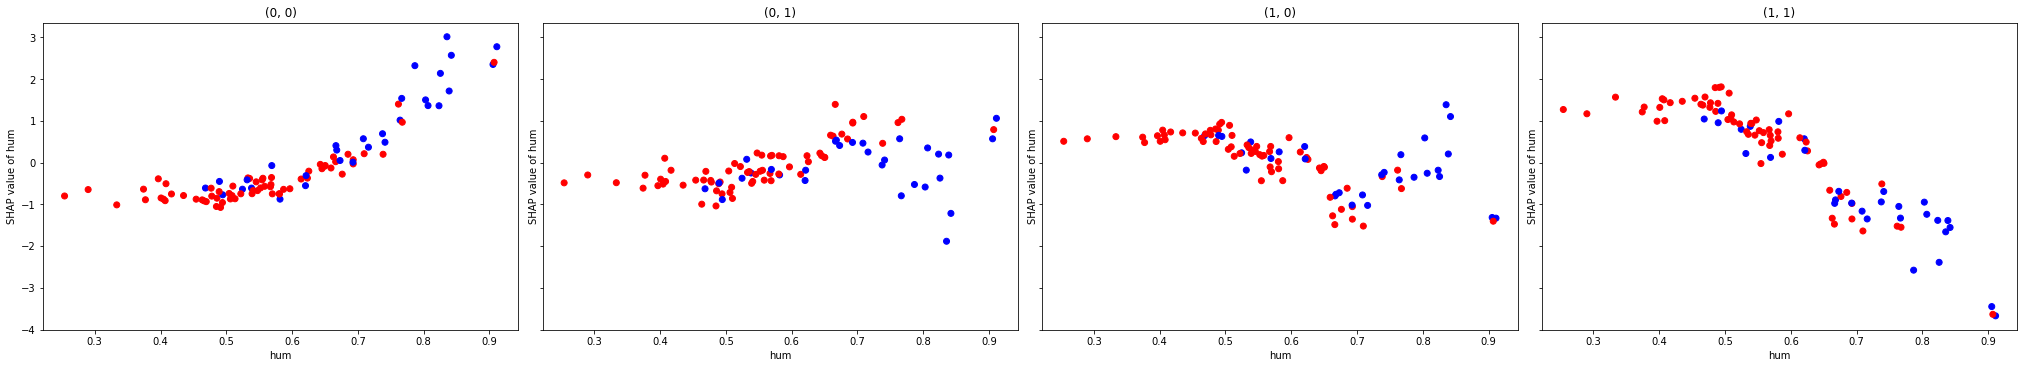

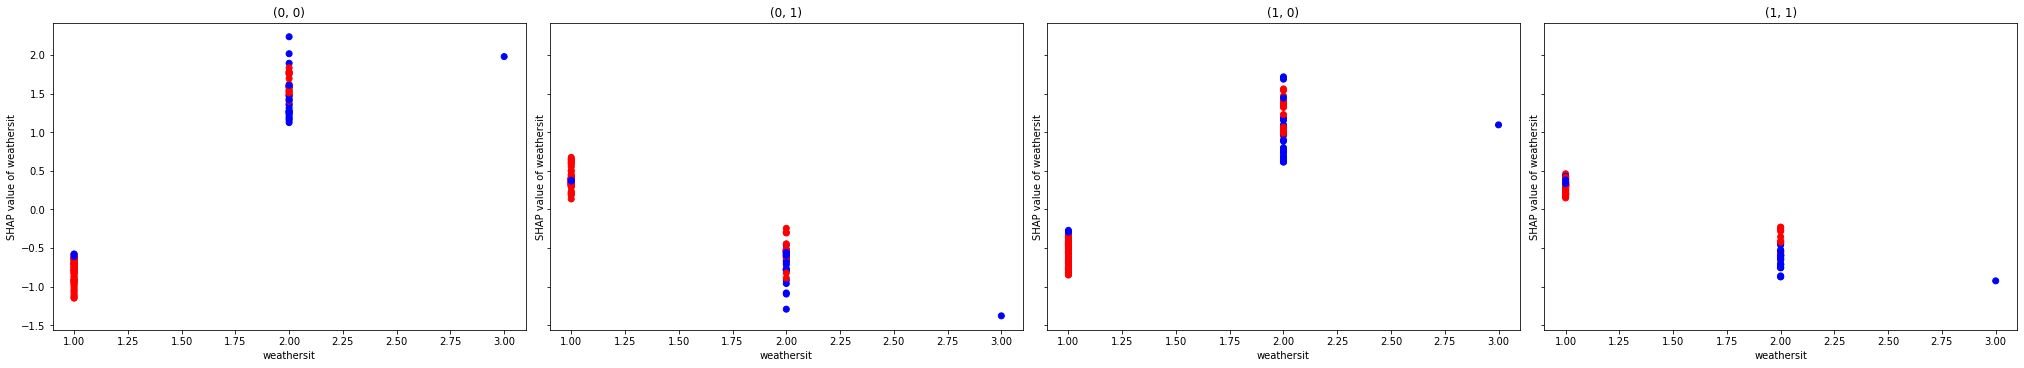

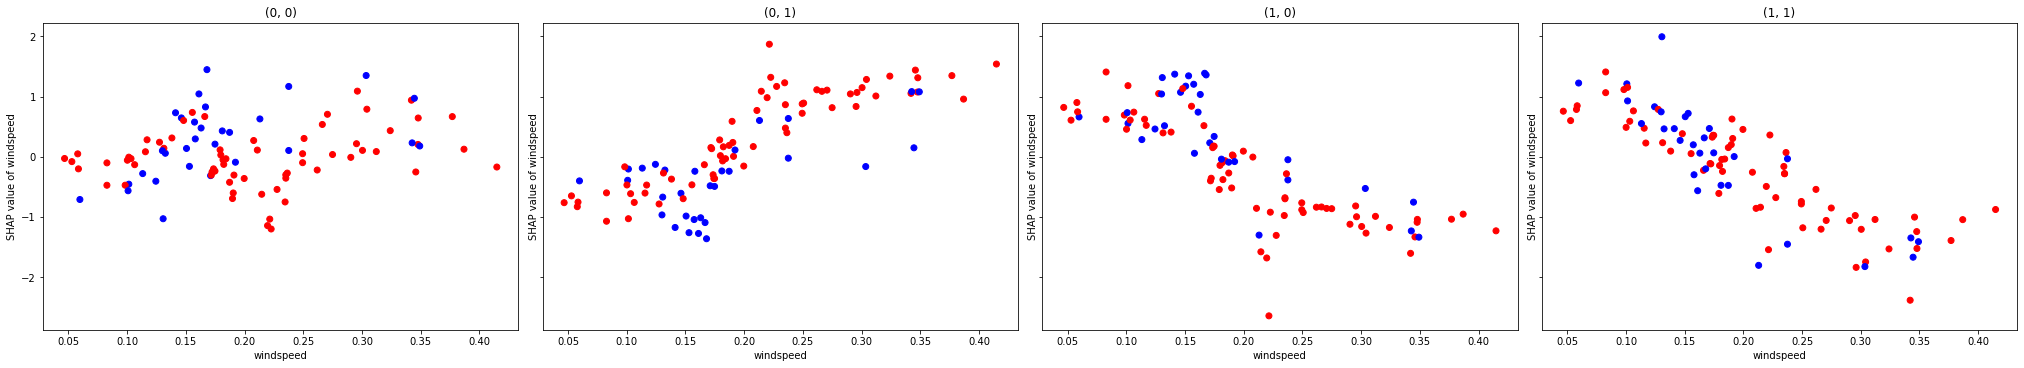

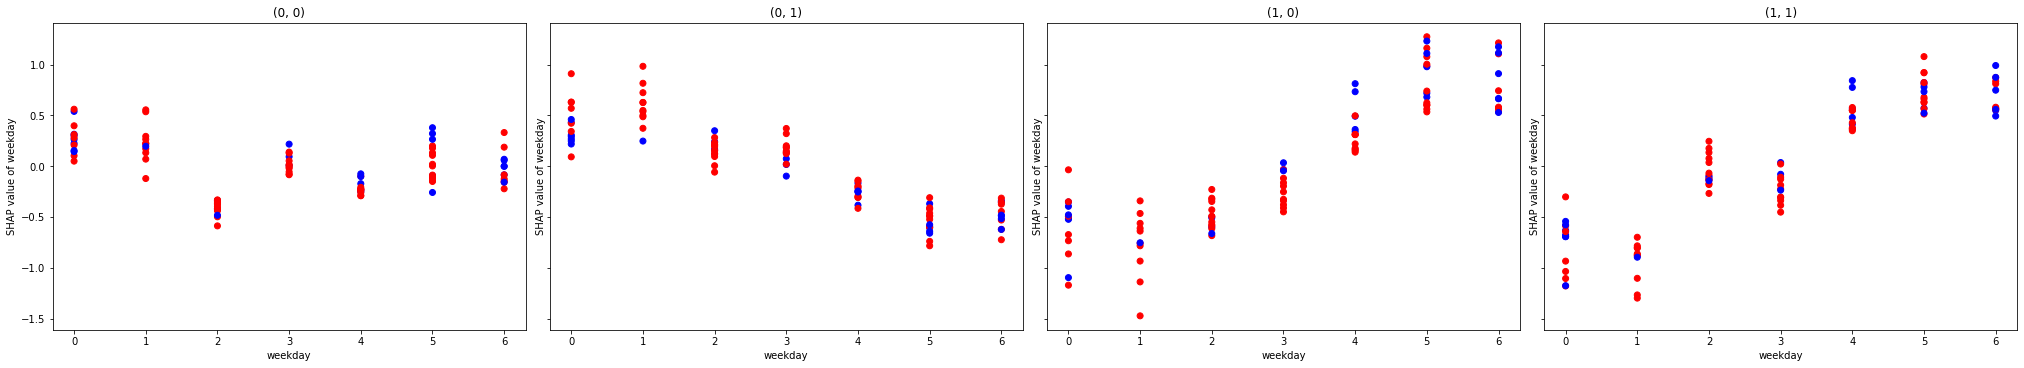

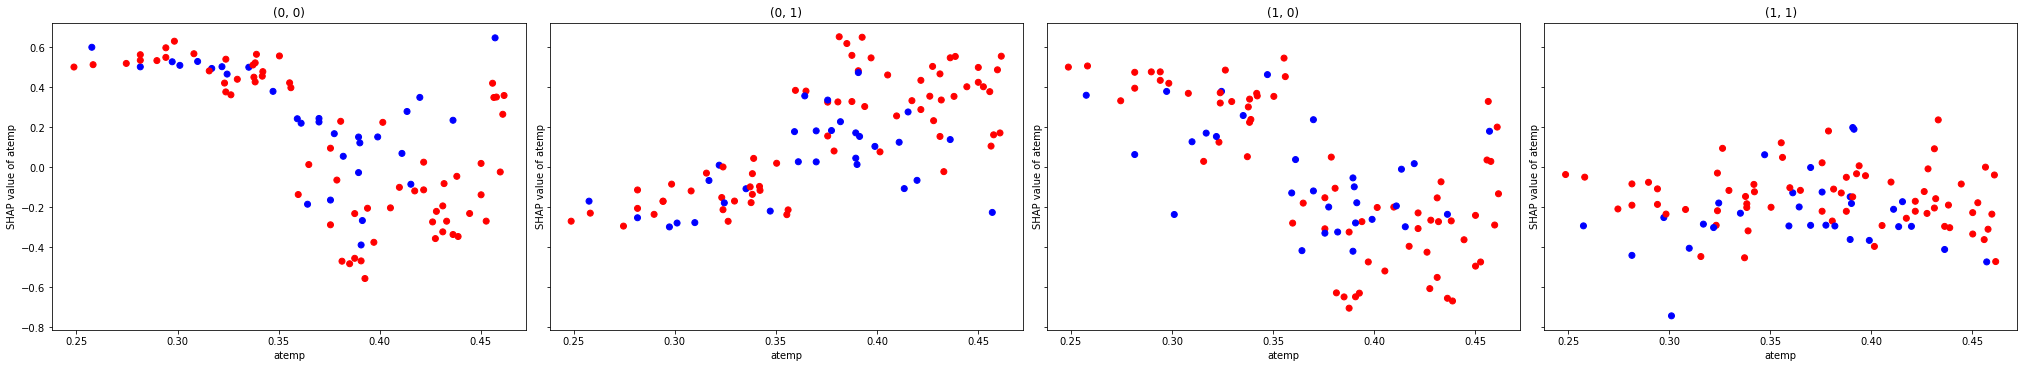

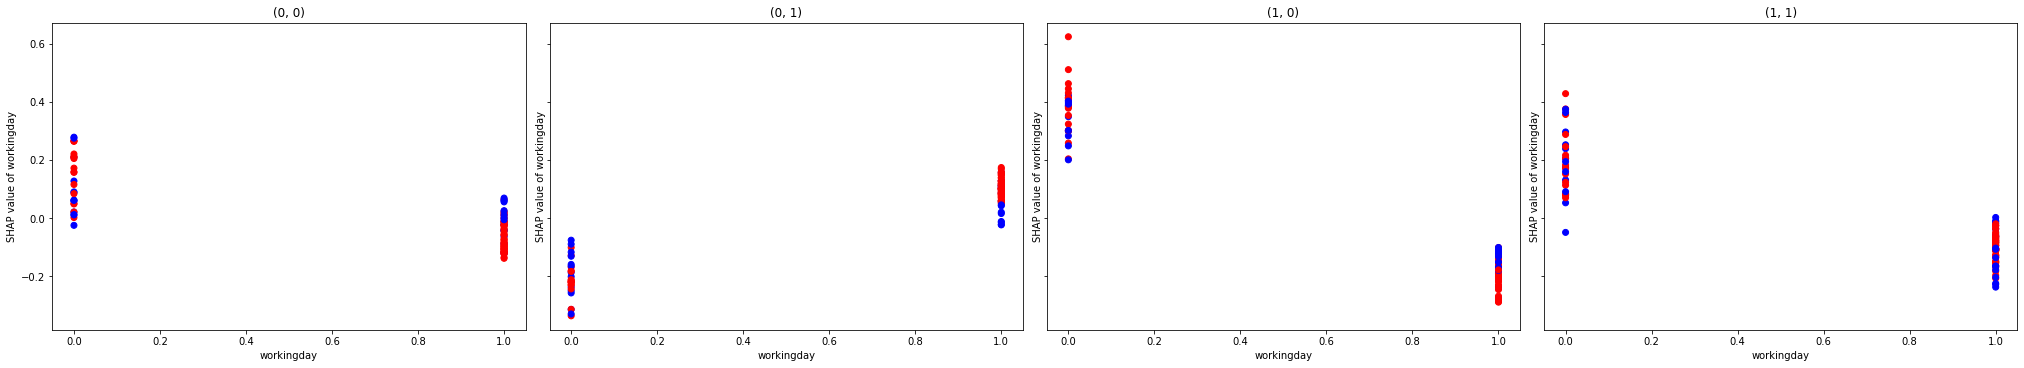

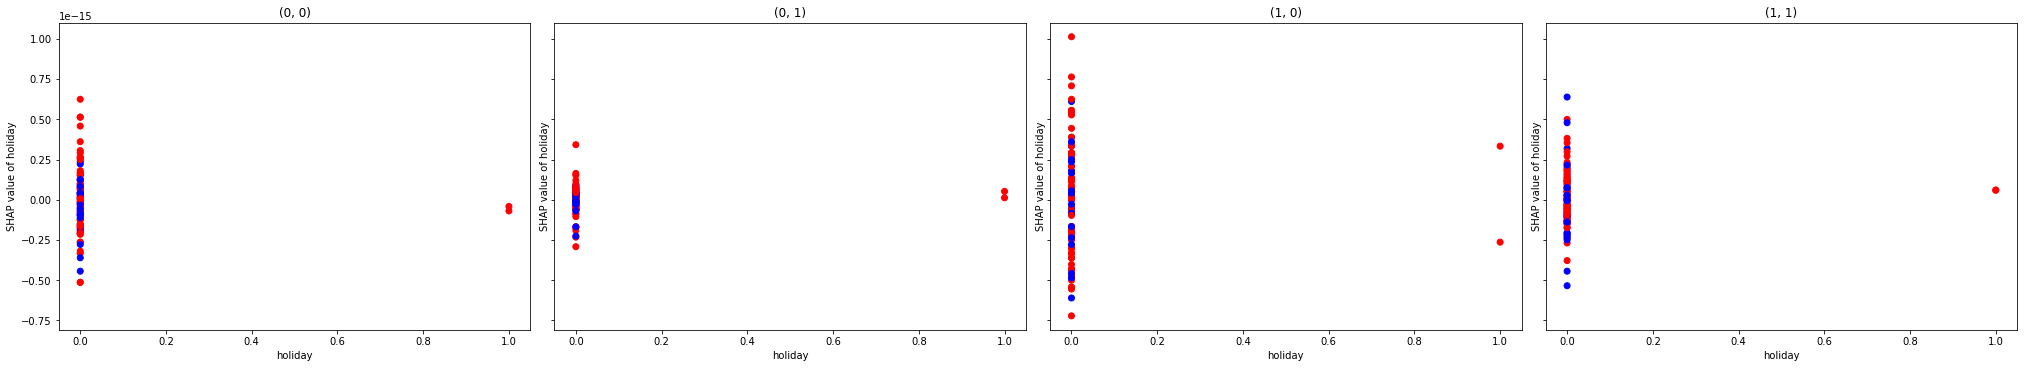

In [24]:
for feature in feature_order[1:]:
    clustering.plot_feature(feature)

In [25]:
clustering.test(hum=0.8)

before  after
(0, 0)     NaN     12
(0, 1)    66.0     54

In [26]:
clustering.test(temp=0.25, hum=0.8)

before  after
(0, 0)     NaN     28
(0, 1)    66.0     38

In [78]:
clustering.go_down()

node #721 (level 3)
(0, 1)    41
(0, 0)    13
(1, 1)     2
(1, 0)     2
dtype: int64


Cluster characteristics:
- $0.24 < temp < 0.47$
- $0.24 < atemp < 0.47$
- $10 ≤ mnth$
- $season = 4$

Differences:
- $0.25 < temp$

Counterfactuals:
- $mnth=1, season=1, temp=0.24, atemp=0.24 \rightarrow (0,0)$
- $temp=.47, atemp=0.6, mnth=6, season=3 \rightarrow (1,1)$

In [28]:
for feature in global_feature_order:
    print(comparer.feature_names[feature])
    display(clustering.describe_feature(feature))

temp


global  local-all  local-diff
count  366.000000  58.000000   41.000000
mean     0.504081   0.352320    0.357493
std      0.176112   0.055476    0.059542
min      0.107500   0.245833    0.255833
25%      0.347708   0.314545    0.313333
50%      0.514167   0.346250    0.352174
75%      0.653959   0.383958    0.393333
max      0.861667   0.468333    0.468333

mnth


global  local-all  local-diff
count  366.000000  58.000000   41.000000
mean     6.513661  11.120690   11.073171
std      3.455958   0.702816    0.647698
min      1.000000  10.000000   10.000000
25%      4.000000  11.000000   11.000000
50%      7.000000  11.000000   11.000000
75%      9.750000  12.000000   11.000000
max     12.000000  12.000000   12.000000

season


global  local-all  local-diff
count  366.000000       58.0        41.0
mean     2.494536        4.0         4.0
std      1.112185        0.0         0.0
min      1.000000        4.0         4.0
25%      2.000000        4.0         4.0
50%      2.500000        4.0         4.0
75%      3.000000        4.0         4.0
max      4.000000        4.0         4.0

hum


global  local-all  local-diff
count  366.000000  58.000000   41.000000
mean     0.612166   0.620920    0.587337
std      0.134206   0.127880    0.104772
min      0.254167   0.333478    0.333478
25%      0.508125   0.533542    0.522083
50%      0.611875   0.605209    0.567083
75%      0.711146   0.690938    0.650417
max      0.925000   0.911250    0.907083

windspeed


global  local-all  local-diff
count  366.000000  58.000000   41.000000
mean     0.189572   0.174184    0.185270
std      0.078194   0.076631    0.085236
min      0.046650   0.046650    0.046650
25%      0.133721   0.125159    0.115522
50%      0.174750   0.168846    0.181596
75%      0.231196   0.214171    0.235067
max      0.441563   0.376871    0.376871

weathersit


global  local-all  local-diff
count  366.000000  58.000000   41.000000
mean     1.368852   1.396552    1.219512
std      0.516057   0.493454    0.419058
min      1.000000   1.000000    1.000000
25%      1.000000   1.000000    1.000000
50%      1.000000   1.000000    1.000000
75%      2.000000   2.000000    1.000000
max      3.000000   2.000000    2.000000

atemp


global  local-all  local-diff
count  366.000000  58.000000   41.000000
mean     0.481852   0.352875    0.356672
std      0.156756   0.054927    0.059054
min      0.101658   0.248742    0.248742
25%      0.350685   0.318168    0.323225
50%      0.497779   0.344683    0.342162
75%      0.607646   0.389987    0.401500
max      0.804913   0.460846    0.460846

weekday


global  local-all  local-diff
count  366.000000  58.000000   41.000000
mean     2.986339   3.017241    3.048780
std      2.006108   1.995533    1.883497
min      0.000000   0.000000    0.000000
25%      1.000000   1.250000    2.000000
50%      3.000000   3.000000    3.000000
75%      5.000000   5.000000    5.000000
max      6.000000   6.000000    6.000000

workingday


global  local-all  local-diff
count  366.000000  58.000000   41.000000
mean     0.683060   0.672414    0.731707
std      0.465921   0.473432    0.448575
min      0.000000   0.000000    0.000000
25%      0.000000   0.000000    0.000000
50%      1.000000   1.000000    1.000000
75%      1.000000   1.000000    1.000000
max      1.000000   1.000000    1.000000

holiday


global  local-all  local-diff
count  366.000000  58.000000   41.000000
mean     0.030055   0.034483    0.048780
std      0.170971   0.184059    0.218085
min      0.000000   0.000000    0.000000
25%      0.000000   0.000000    0.000000
50%      0.000000   0.000000    0.000000
75%      0.000000   0.000000    0.000000
max      1.000000   1.000000    1.000000

In [29]:
clustering.test(temp=0.24, atemp=.24)

before  after
(0, 0)     NaN      7
(0, 1)    41.0     34

In [30]:
clustering.test(mnth=1)

before  after
(0, 0)     NaN      2
(0, 1)    41.0     39

In [31]:
clustering.test(season=1)

before  after
(0, 0)     NaN     29
(0, 1)    41.0     12

In [32]:
clustering.test(mnth=1, season=1)

before  after
(0, 0)     NaN     30
(0, 1)    41.0     11

In [33]:
clustering.test(mnth=1, season=1, temp=0.24, atemp=.24)

before  after
(0, 0)     NaN   41.0
(0, 1)    41.0    NaN

In [34]:
clustering.test(temp=.47, atemp=0.6)

before  after
(0, 1)    41.0      6
(1, 1)     NaN     35

In [35]:
clustering.test(temp=.47, atemp=0.6, mnth=6, season=3)

before  after
(0, 1)    41.0      4
(1, 1)     NaN     37

Now for this cluster, if temperature was lower and month was January, both classifiers would predict 0.

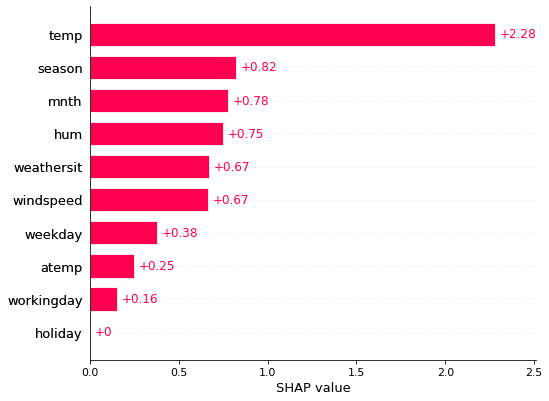

In [37]:
feature_order, feature_importances = calc_feature_order(clustering.shap_values[:, :, clustering.classes])
plot_feature_importance_bar(feature_importances)

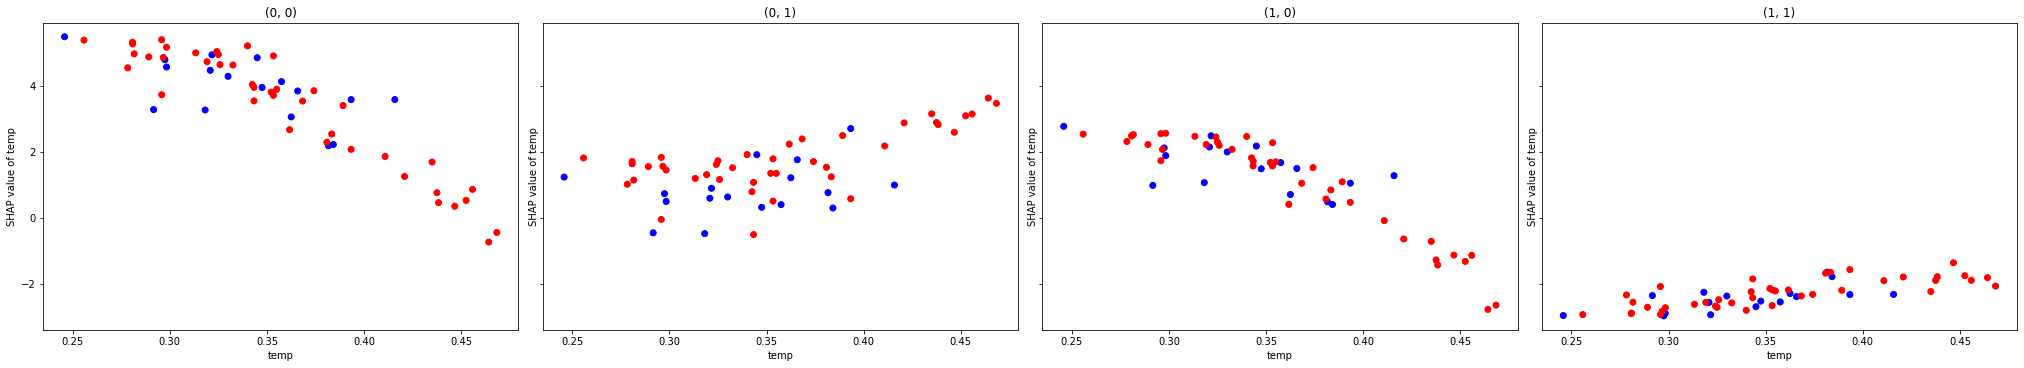

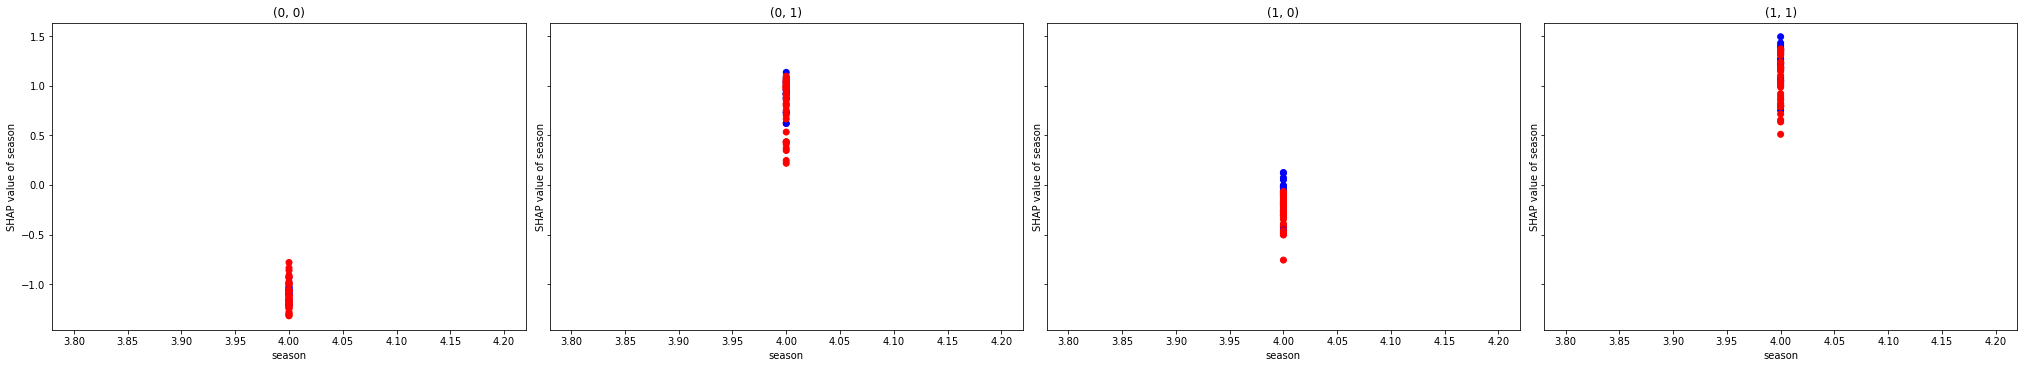

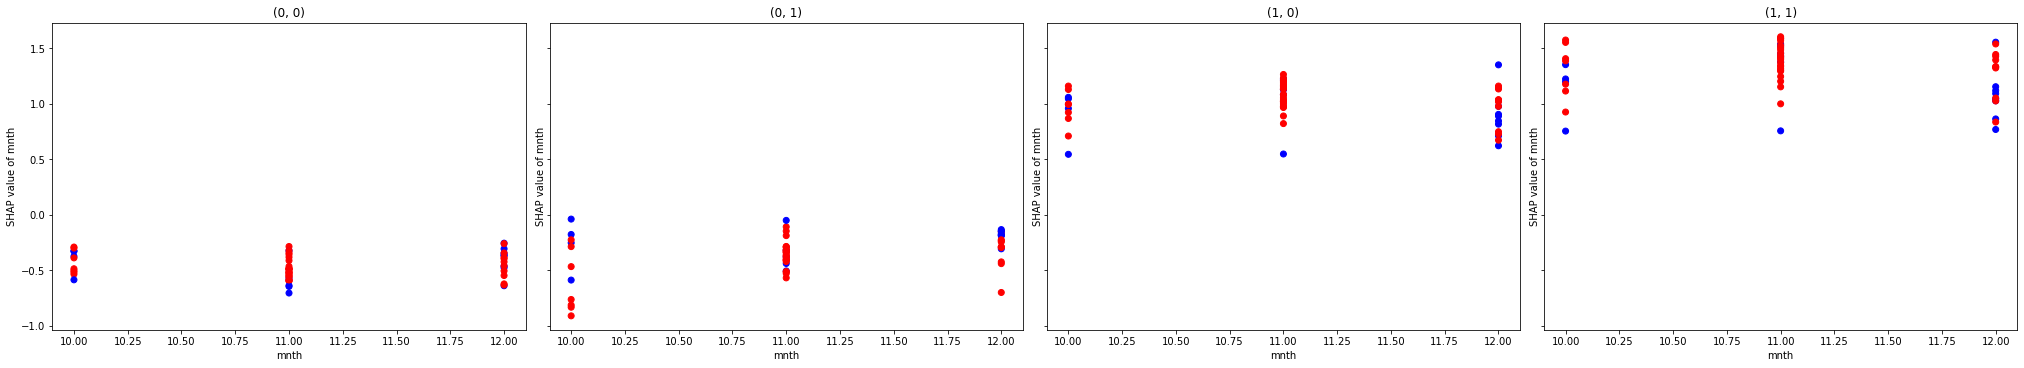

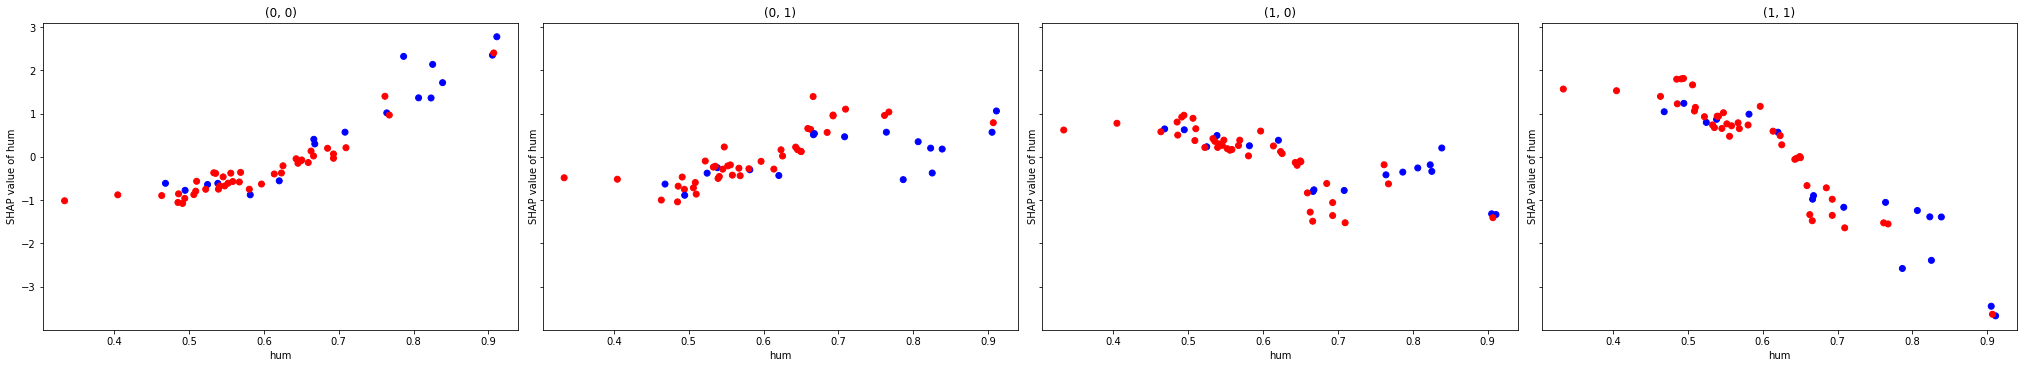

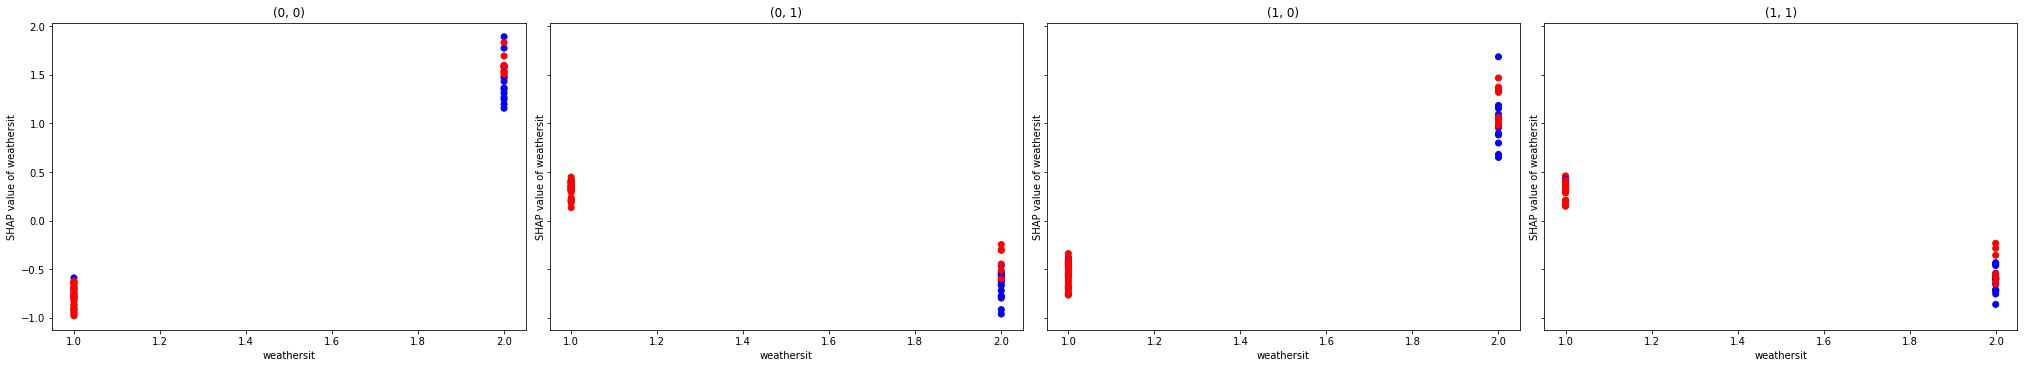

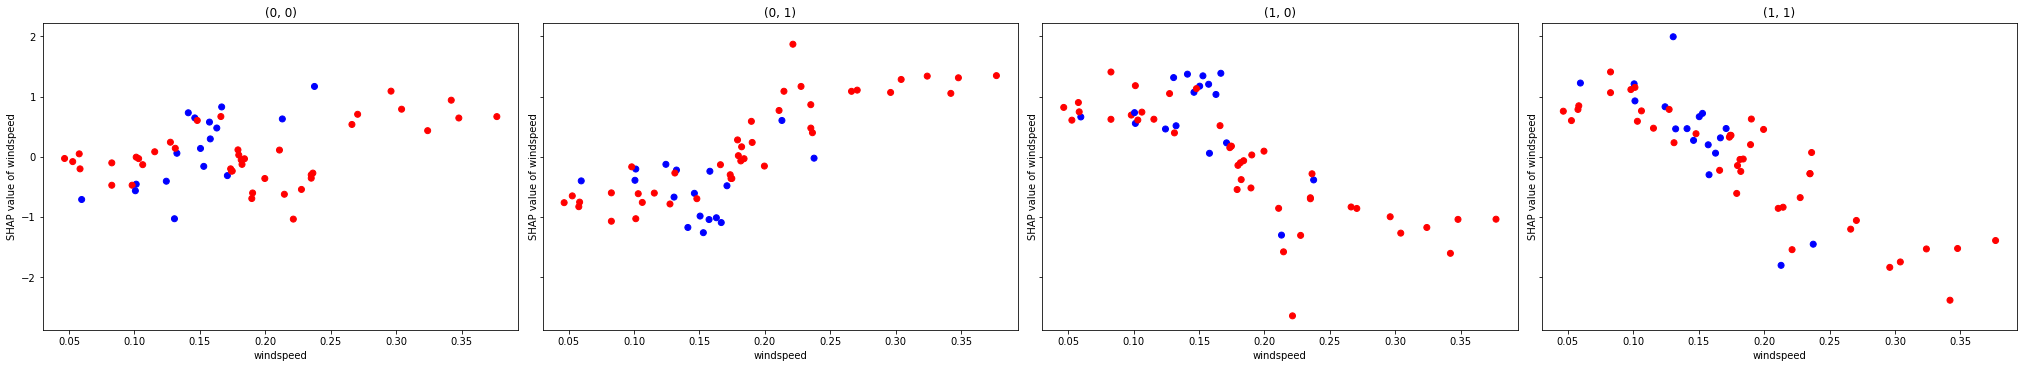

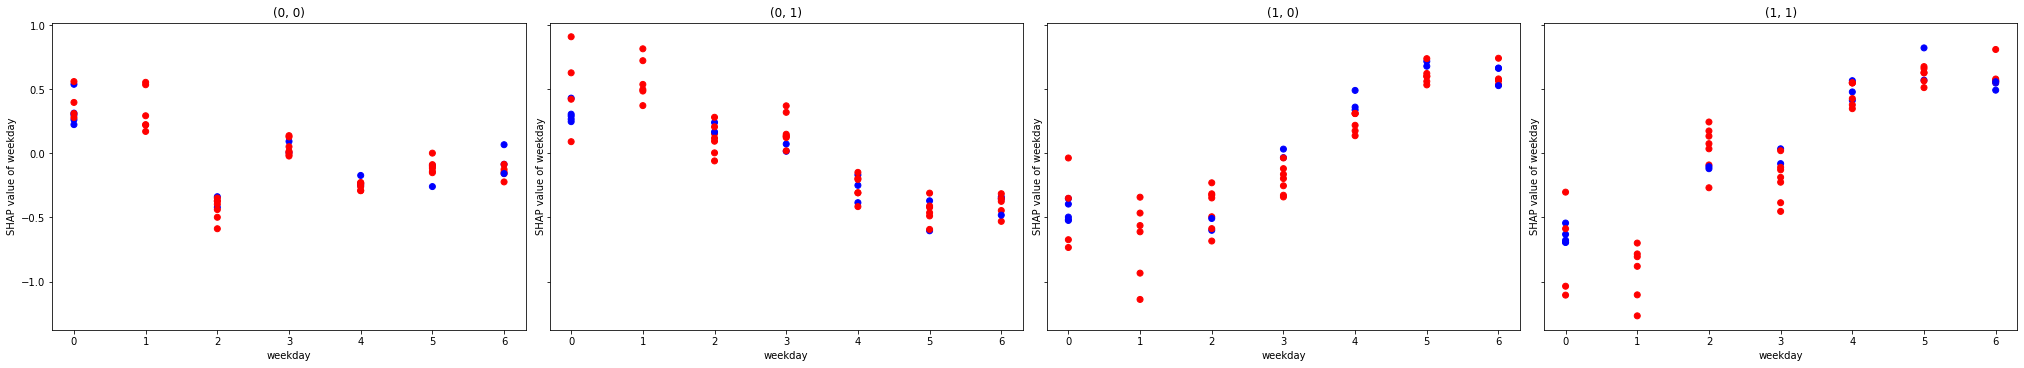

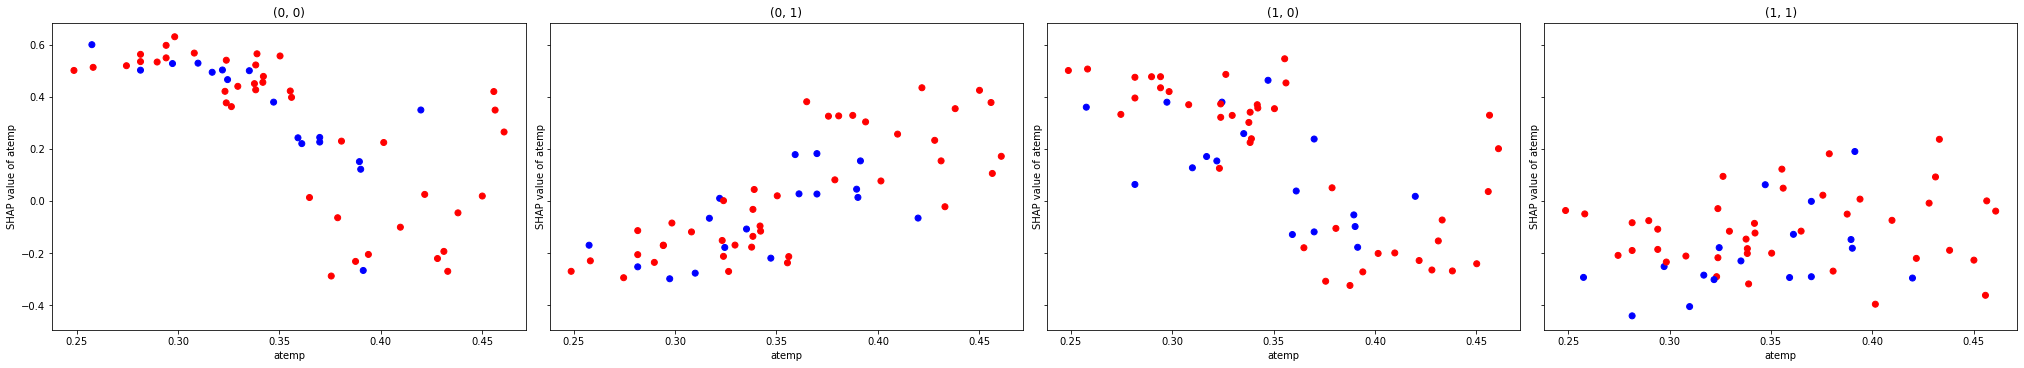

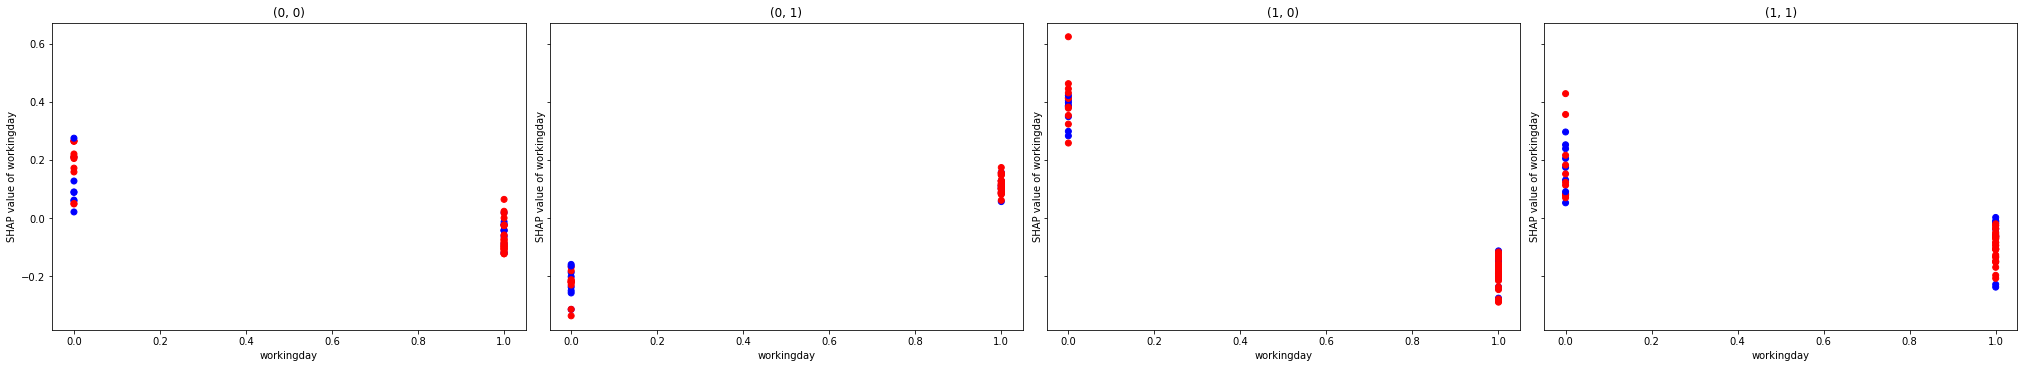

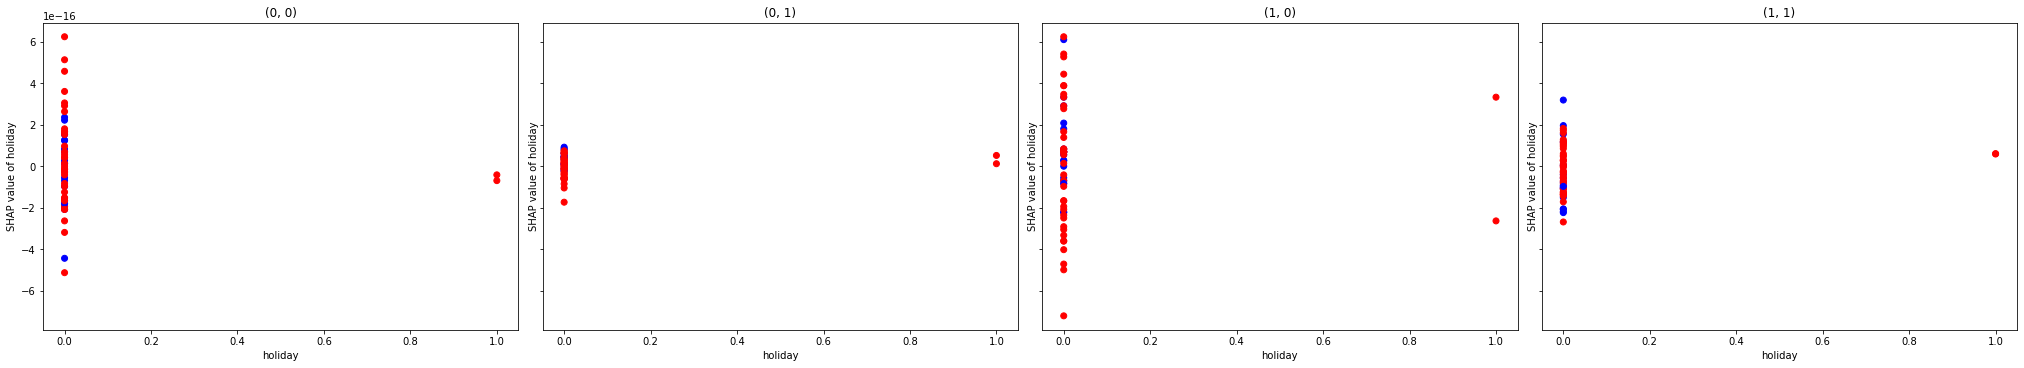

In [38]:
for feature in feature_order:
    clustering.plot_feature(feature)

In [47]:
clustering.test(temp=0.25, hum=0.8, atemp=0.25)

before  after
(0, 0)     NaN     16
(0, 1)    41.0     25

In [40]:
clustering.test(hum=0.3, windspeed=0.05, atemp=0.25, workingday=0)

before  after
(0, 0)     NaN      7
(0, 1)    41.0     23
(1, 0)     NaN      1
(1, 1)     NaN     10

The inner cluster effects are still not very pronounced and do not allow to find counterfactuals.

### Cluster 2

In [79]:
clustering.get_next()

node #725 (level 2)
(0, 1)    66
(0, 0)    26
(1, 1)     2
(1, 0)     2
dtype: int64
node #723 (level 3)
(0, 1)    25
(0, 0)    13
dtype: int64


Cluster characteristics:
- $0.32 < temp < 0.47$
- $hum < 0.85$
- $0.30 < atemp < 0.47$
- $1 ≤ mnth ≤ 4$
- $1 ≤ season ≤ 2$
- $holiday = 0$ (not relevant)

Differences:
- $hum < 0.74$
- $weathersit ≤ 2$ (not relevant)
- $0.31 < atemp$

Counterfactuals:
- $temp=0.32, mnth=2, season=1 \rightarrow (0,0)$
- $temp=0.47, atemp=0.47, mnth=6, season=2 \rightarrow (1,1)$

In [42]:
for feature in global_feature_order:
    print(comparer.feature_names[feature])
    display(clustering.describe_feature(feature))

temp


global  local-all  local-diff
count  366.000000  38.000000   25.000000
mean     0.504081   0.411488    0.419107
std      0.176112   0.038527    0.038709
min      0.107500   0.321667    0.323333
25%      0.347708   0.390833    0.397500
50%      0.514167   0.412083    0.425833
75%      0.653959   0.441250    0.446667
max      0.861667   0.466667    0.466667

mnth


global  local-all  local-diff
count  366.000000  38.000000   25.000000
mean     6.513661   3.052632    3.400000
std      3.455958   1.113732    0.816497
min      1.000000   1.000000    1.000000
25%      4.000000   2.250000    3.000000
50%      7.000000   3.000000    4.000000
75%      9.750000   4.000000    4.000000
max     12.000000   4.000000    4.000000

season


global  local-all  local-diff
count  366.000000  38.000000   25.000000
mean     2.494536   1.578947    1.720000
std      1.112185   0.500355    0.458258
min      1.000000   1.000000    1.000000
25%      2.000000   1.000000    1.000000
50%      2.500000   2.000000    2.000000
75%      3.000000   2.000000    2.000000
max      4.000000   2.000000    2.000000

hum


global  local-all  local-diff
count  366.000000  38.000000   25.000000
mean     0.612166   0.550150    0.475468
std      0.134206   0.151555    0.109758
min      0.254167   0.254167    0.254167
25%      0.508125   0.439792    0.407083
50%      0.611875   0.522500    0.469565
75%      0.711146   0.675417    0.554583
max      0.925000   0.842083    0.738333

windspeed


global  local-all  local-diff
count  366.000000  38.000000   25.000000
mean     0.189572   0.236338    0.243849
std      0.078194   0.082061    0.081509
min      0.046650   0.100133    0.100133
25%      0.133721   0.172890    0.187192
50%      0.174750   0.228529    0.249375
75%      0.231196   0.299109    0.295274
max      0.441563   0.414800    0.414800

weathersit


global  local-all  local-diff
count  366.000000  38.000000   25.000000
mean     1.368852   1.447368    1.200000
std      0.516057   0.554947    0.408248
min      1.000000   1.000000    1.000000
25%      1.000000   1.000000    1.000000
50%      1.000000   1.000000    1.000000
75%      2.000000   2.000000    1.000000
max      3.000000   3.000000    2.000000

atemp


global  local-all  local-diff
count  366.000000  38.000000   25.000000
mean     0.481852   0.405196    0.411384
std      0.156756   0.038852    0.038652
min      0.101658   0.301125    0.315654
25%      0.350685   0.382729    0.387604
50%      0.497779   0.408127    0.421708
75%      0.607646   0.435124    0.438750
max      0.804913   0.461483    0.461483

weekday


global  local-all  local-diff
count  366.000000  38.000000   25.000000
mean     2.986339   3.131579    2.880000
std      2.006108   2.029126    1.921805
min      0.000000   0.000000    0.000000
25%      1.000000   1.250000    1.000000
50%      3.000000   3.000000    3.000000
75%      5.000000   5.000000    5.000000
max      6.000000   6.000000    6.000000

workingday


global  local-all  local-diff
count  366.000000  38.000000   25.000000
mean     0.683060   0.736842    0.800000
std      0.465921   0.446258    0.408248
min      0.000000   0.000000    0.000000
25%      0.000000   0.250000    1.000000
50%      1.000000   1.000000    1.000000
75%      1.000000   1.000000    1.000000
max      1.000000   1.000000    1.000000

holiday


global  local-all  local-diff
count  366.000000       38.0        25.0
mean     0.030055        0.0         0.0
std      0.170971        0.0         0.0
min      0.000000        0.0         0.0
25%      0.000000        0.0         0.0
50%      0.000000        0.0         0.0
75%      0.000000        0.0         0.0
max      1.000000        0.0         0.0

In [52]:
clustering.test(temp=0.32)

before  after
(0, 0)     NaN     10
(0, 1)    25.0     15

In [55]:
clustering.test(temp=0.47)

before  after
(0, 1)    25.0     24
(1, 1)     NaN      1

In [65]:
clustering.test(atemp=0.30)

before  after
(0, 0)     NaN      2
(0, 1)    25.0     23

In [57]:
clustering.test(atemp=0.47)

before  after
(0, 1)      25     25

In [66]:
clustering.test(temp=0.32, atemp=0.30)

before  after
(0, 0)     NaN     10
(0, 1)    25.0     15

In [59]:
clustering.test(temp=0.47, atemp=0.47)

before  after
(0, 1)    25.0     24
(1, 1)     NaN      1

In [79]:
clustering.test(mnth=5)

before  after
(0, 0)     NaN      1
(0, 1)    25.0     24

In [81]:
clustering.test(mnth=5)

before  after
(0, 0)     NaN      1
(0, 1)    25.0     24

In [82]:
clustering.test(temp=0.47, atemp=0.47, mnth=5)

before  after
(0, 1)    25.0      9
(1, 1)     NaN     16

In [83]:
clustering.test(temp=0.47, atemp=0.47, mnth=6, season=2)

before  after
(0, 1)    25.0      3
(1, 1)     NaN     22

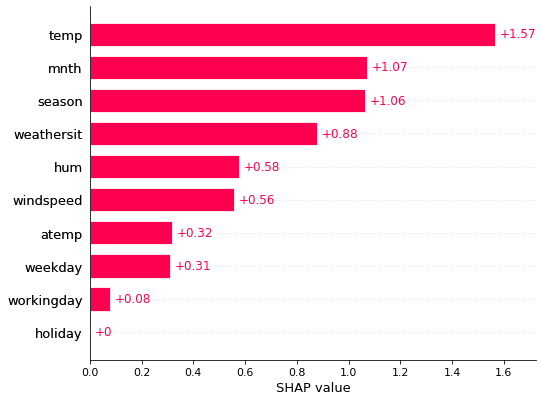

In [73]:
feature_order, feature_importances = calc_feature_order(clustering.shap_values[:, :, clustering.classes])
plot_feature_importance_bar(feature_importances)

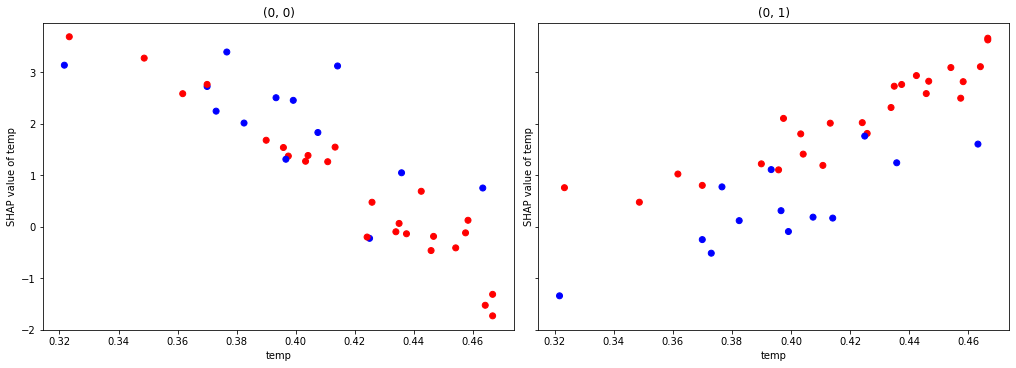

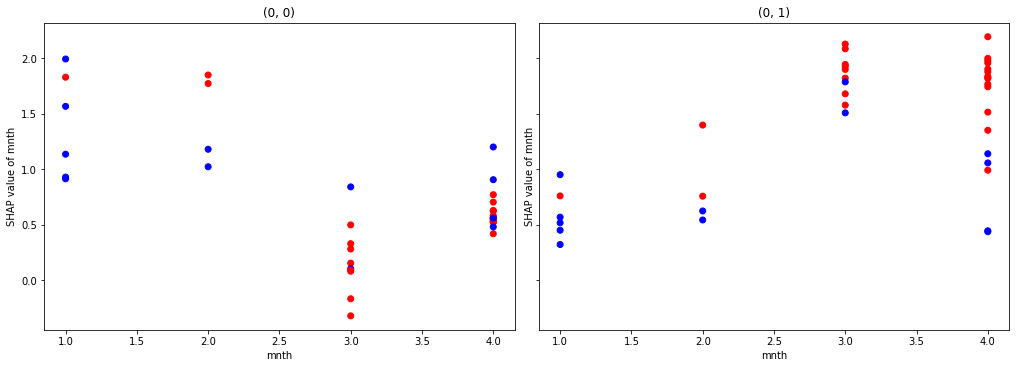

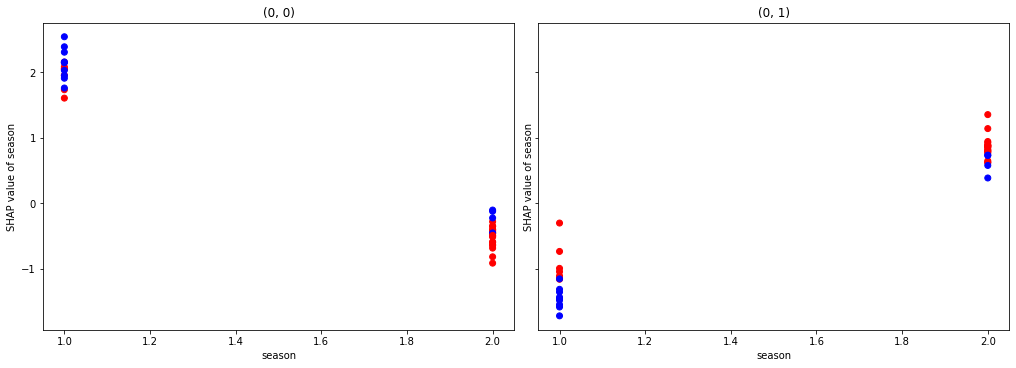

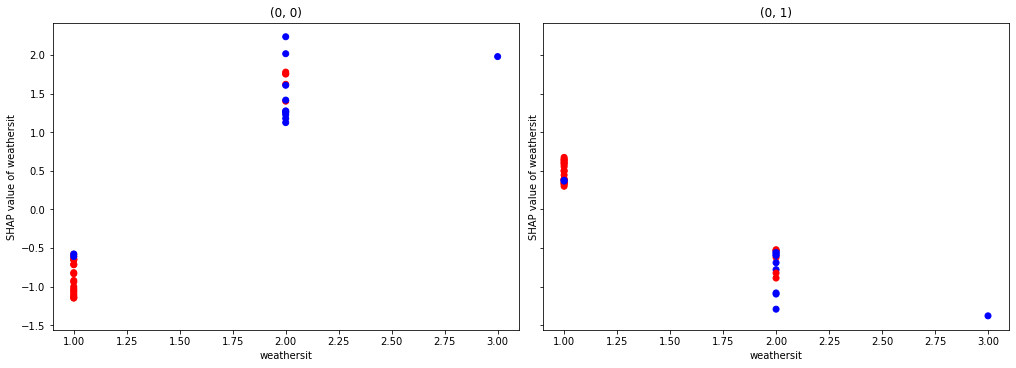

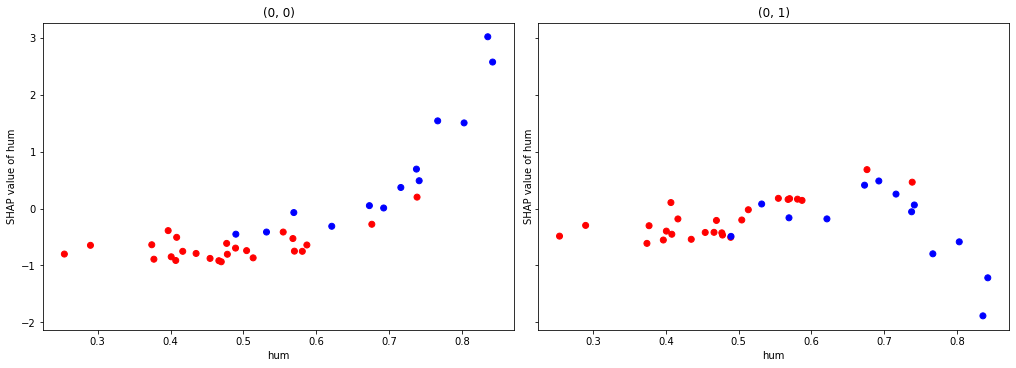

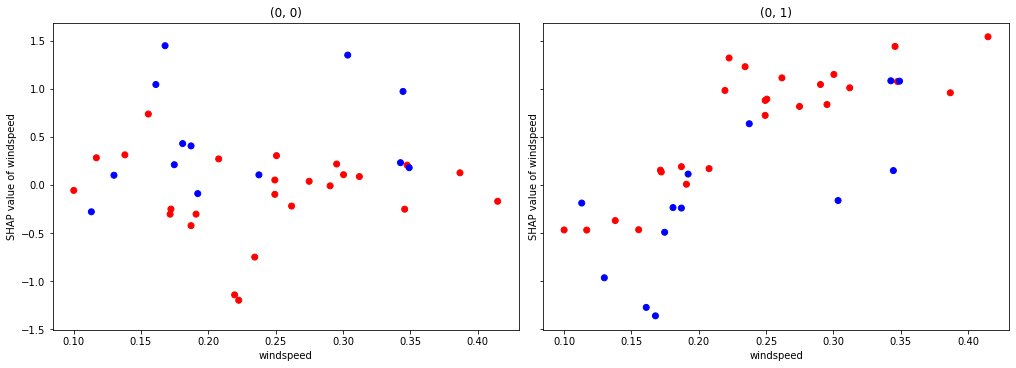

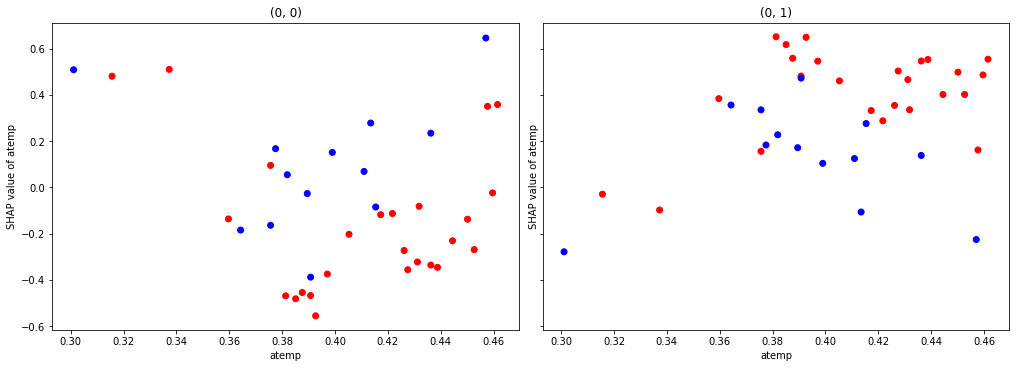

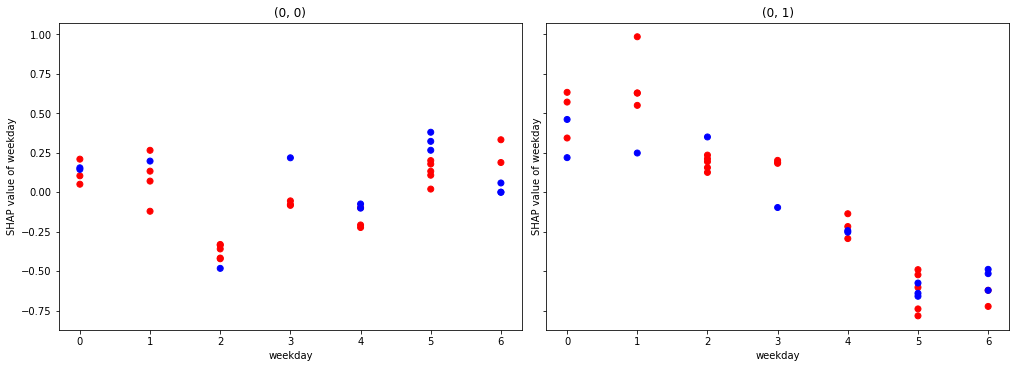

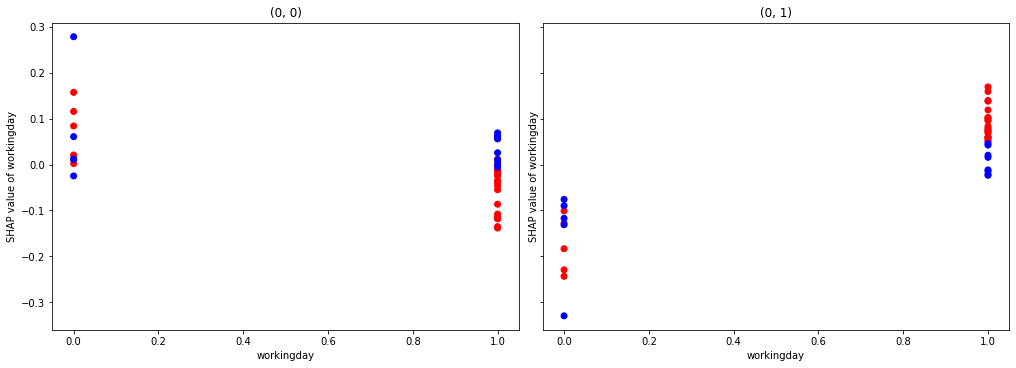

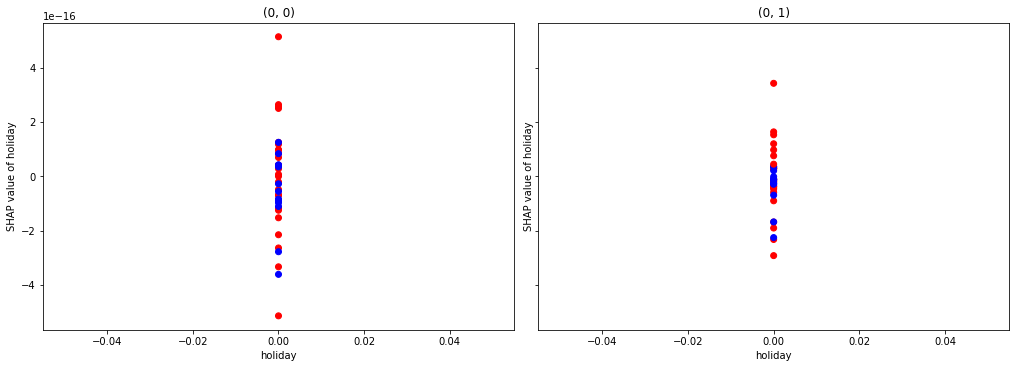

In [75]:
for feature in feature_order:
    clustering.plot_feature(feature)

In [78]:
clustering.test(temp=0.32, mnth=2, season=1)

before  after
(0, 0)     NaN   25.0
(0, 1)    25.0    NaN

### Cluster 3

In [80]:
clustering.get_next()

node #725 (level 2)
(0, 1)    66
(0, 0)    26
(1, 1)     2
(1, 0)     2
dtype: int64
node #728 (level 1)
(0, 0)    91
(0, 1)    66
(1, 1)     2
(1, 0)     2
dtype: int64
node #730 (level 0)
(0, 1)    145
(1, 1)    121
(0, 0)     98
(1, 0)      2
dtype: int64
node #729 (level 1)
(1, 1)    119
(0, 1)     79
(0, 0)      7
dtype: int64


Cluster characteristics:
- $0.43 < temp$
- $2 ≤ mnth$
- $0.24 < atemp$

Differences:
- 0.43 < atemp

Counterfactuals:
- $temp=0.3, mnth=1, season=1, atemp=0.24 \rightarrow (0,0)$
- $temp=0.7, hum=0.4, mnth=6, season=3, atemp=0.65 \rightarrow (1,1)$

In [46]:
for feature in global_feature_order:
    print(comparer.feature_names[feature])
    display(clustering.describe_feature(feature))

temp


global   local-all  local-diff
count  366.000000  205.000000   79.000000
mean     0.504081    0.638545    0.636962
std      0.176112    0.097012    0.123561
min      0.107500    0.435833    0.435833
25%      0.347708    0.561667    0.528750
50%      0.514167    0.635833    0.608333
75%      0.653959    0.717500    0.757916
max      0.861667    0.861667    0.861667

mnth


global   local-all  local-diff
count  366.000000  205.000000   79.000000
mean     6.513661    6.843902    6.000000
std      3.455958    2.140878    2.375084
min      1.000000    2.000000    2.000000
25%      4.000000    5.000000    4.000000
50%      7.000000    7.000000    6.000000
75%      9.750000    9.000000    7.500000
max     12.000000   12.000000   12.000000

season


global   local-all  local-diff
count  366.000000  205.000000   79.000000
mean     2.494536    2.712195    2.481013
std      1.112185    0.779704    0.845209
min      1.000000    1.000000    1.000000
25%      2.000000    2.000000    2.000000
50%      2.500000    3.000000    3.000000
75%      3.000000    3.000000    3.000000
max      4.000000    4.000000    4.000000

hum


global   local-all  local-diff
count  366.000000  205.000000   79.000000
mean     0.612166    0.633726    0.638792
std      0.134206    0.122607    0.132994
min      0.254167    0.275833    0.275833
25%      0.508125    0.545417    0.556875
50%      0.611875    0.635833    0.652500
75%      0.711146    0.722917    0.728541
max      0.925000    0.925000    0.925000

windspeed


global   local-all  local-diff
count  366.000000  205.000000   79.000000
mean     0.189572    0.177883    0.201772
std      0.078194    0.069370    0.073016
min      0.046650    0.064071    0.065929
25%      0.133721    0.129354    0.148006
50%      0.174750    0.165417    0.194029
75%      0.231196    0.223258    0.237881
max      0.441563    0.441563    0.441563

weathersit


global   local-all  local-diff
count  366.000000  205.000000   79.000000
mean     1.368852    1.326829    1.367089
std      0.516057    0.500502    0.510837
min      1.000000    1.000000    1.000000
25%      1.000000    1.000000    1.000000
50%      1.000000    1.000000    1.000000
75%      2.000000    2.000000    2.000000
max      3.000000    3.000000    3.000000

atemp


global   local-all  local-diff
count  366.000000  205.000000   79.000000
mean     0.481852    0.600391    0.605033
std      0.156756    0.084303    0.106406
min      0.101658    0.242400    0.435575
25%      0.350685    0.539150    0.515454
50%      0.497779    0.595975    0.577021
75%      0.607646    0.661629    0.709615
max      0.804913    0.804913    0.804913

weekday


global   local-all  local-diff
count  366.000000  205.000000   79.000000
mean     2.986339    3.004878    2.759494
std      2.006108    1.981526    1.922973
min      0.000000    0.000000    0.000000
25%      1.000000    1.000000    1.000000
50%      3.000000    3.000000    3.000000
75%      5.000000    5.000000    4.000000
max      6.000000    6.000000    6.000000

workingday


global   local-all  local-diff
count  366.000000  205.000000   79.000000
mean     0.683060    0.697561    0.696203
std      0.465921    0.460439    0.462835
min      0.000000    0.000000    0.000000
25%      0.000000    0.000000    0.000000
50%      1.000000    1.000000    1.000000
75%      1.000000    1.000000    1.000000
max      1.000000    1.000000    1.000000

holiday


global   local-all  local-diff
count  366.000000  205.000000   79.000000
mean     0.030055    0.024390    0.050633
std      0.170971    0.154635    0.220648
min      0.000000    0.000000    0.000000
25%      0.000000    0.000000    0.000000
50%      0.000000    0.000000    0.000000
75%      0.000000    0.000000    0.000000
max      1.000000    1.000000    1.000000

In [49]:
clustering.test(temp=0.3)

before  after
(0, 0)     NaN     23
(0, 1)    79.0     56

In [101]:
clustering.test(mnth=1, season=1)

before  after
(0, 0)     NaN      4
(0, 1)    79.0     75

In [53]:
clustering.test(atemp=0.24)

before  after
(0, 0)     NaN      2
(0, 1)    79.0     56
(1, 1)     NaN     21

In [100]:
clustering.test(temp=.3, mnth=1, season=1, atemp=0.24)

before  after
(0, 0)     NaN   79.0
(0, 1)    79.0    NaN

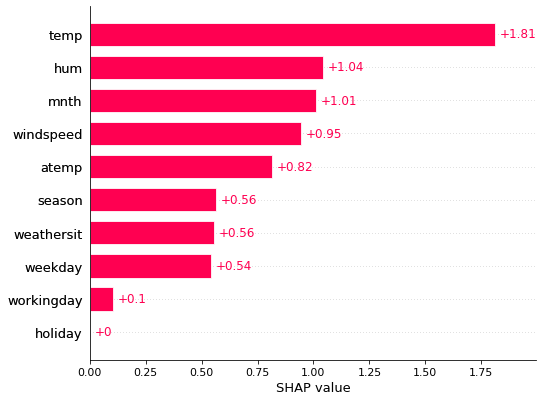

In [55]:
feature_order, feature_importances = calc_feature_order(clustering.shap_values[:, :, clustering.classes])
plot_feature_importance_bar(feature_importances)

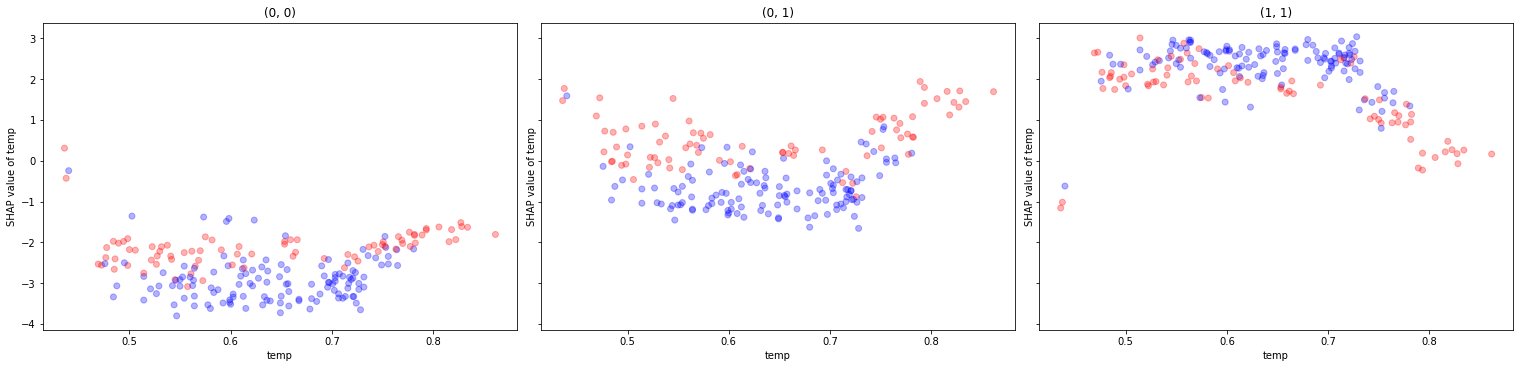

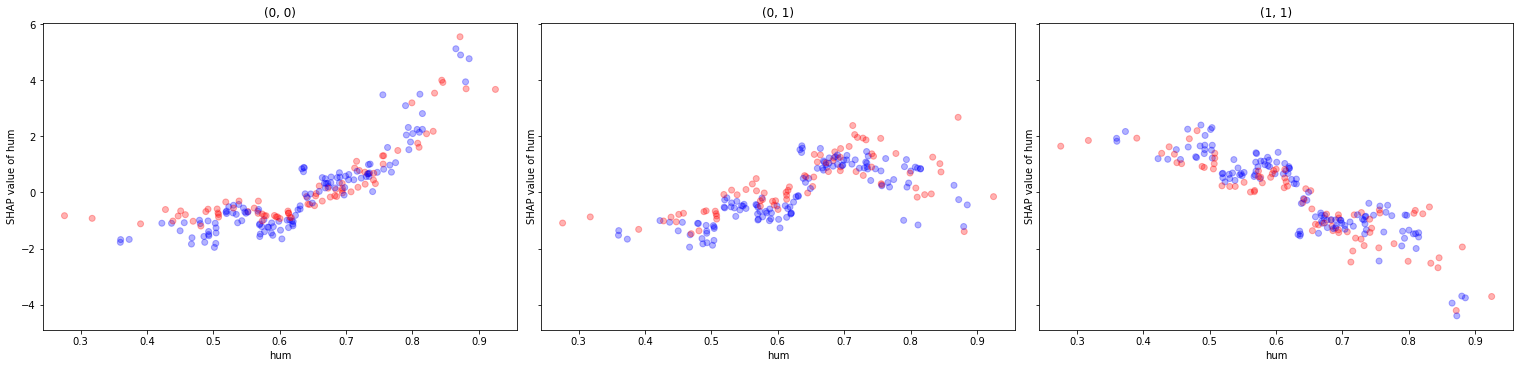

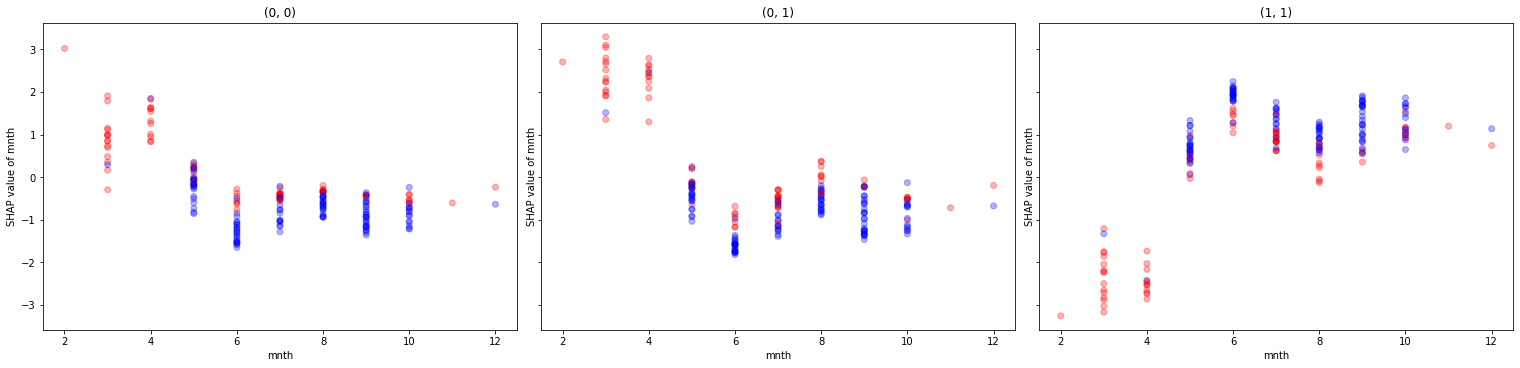

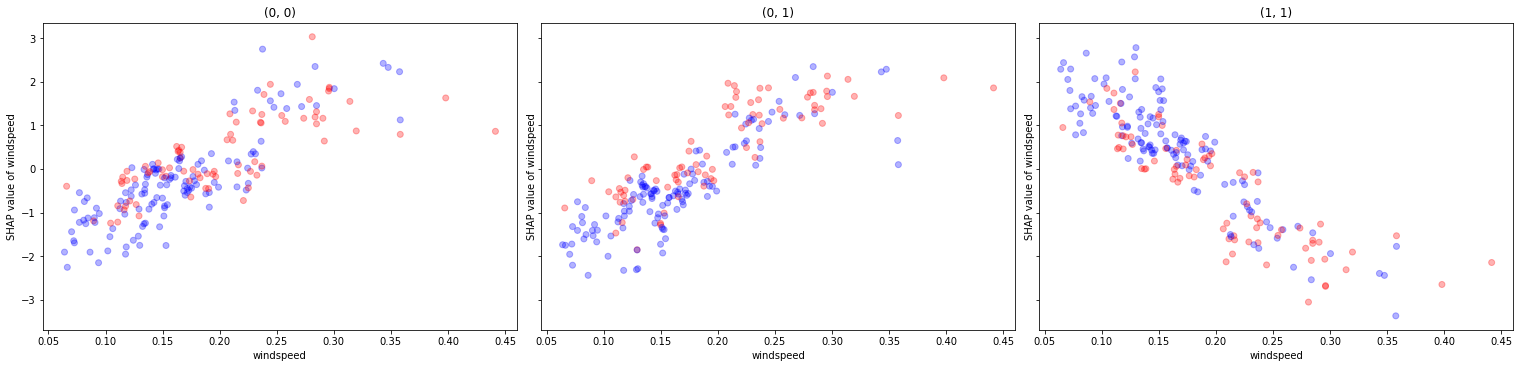

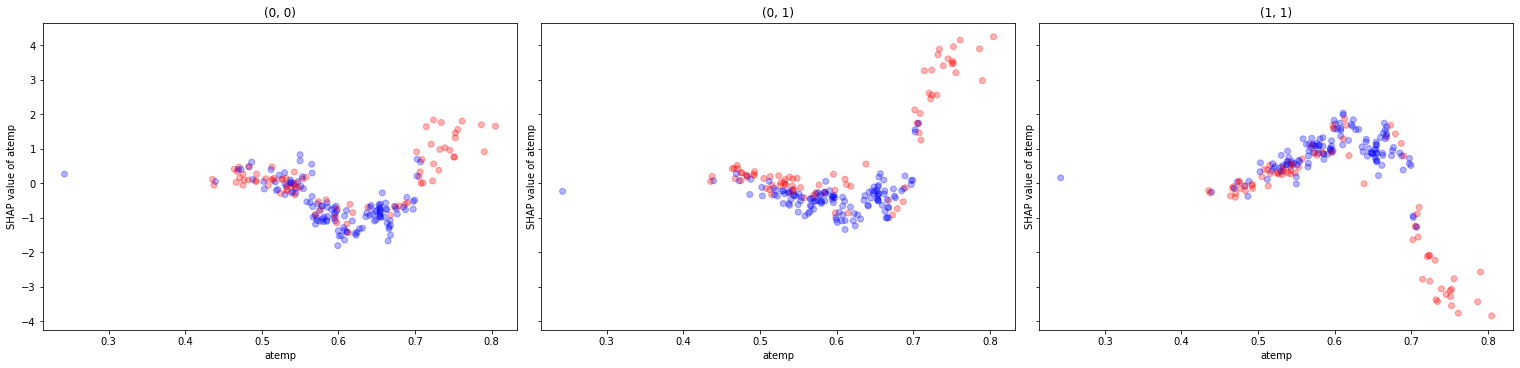

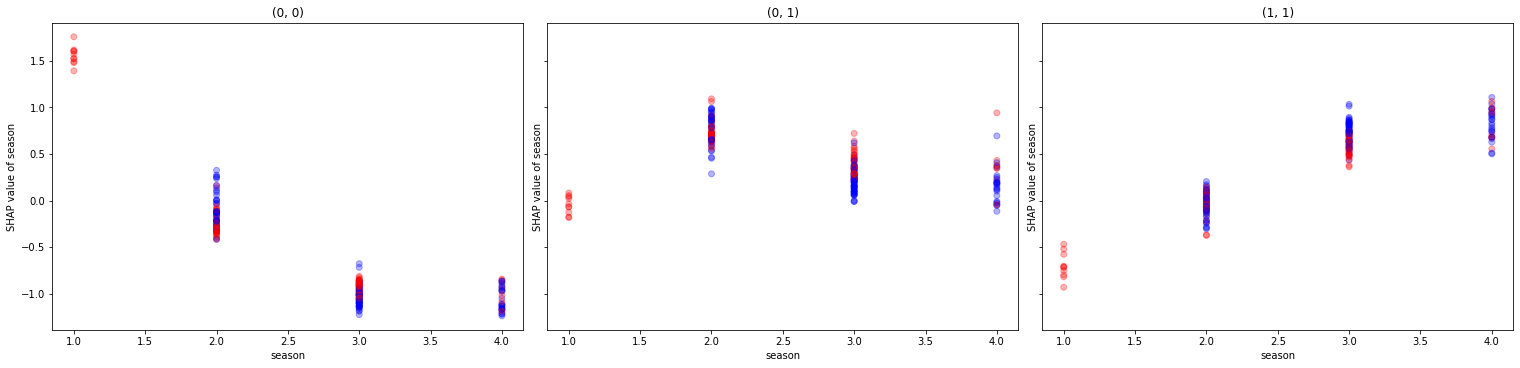

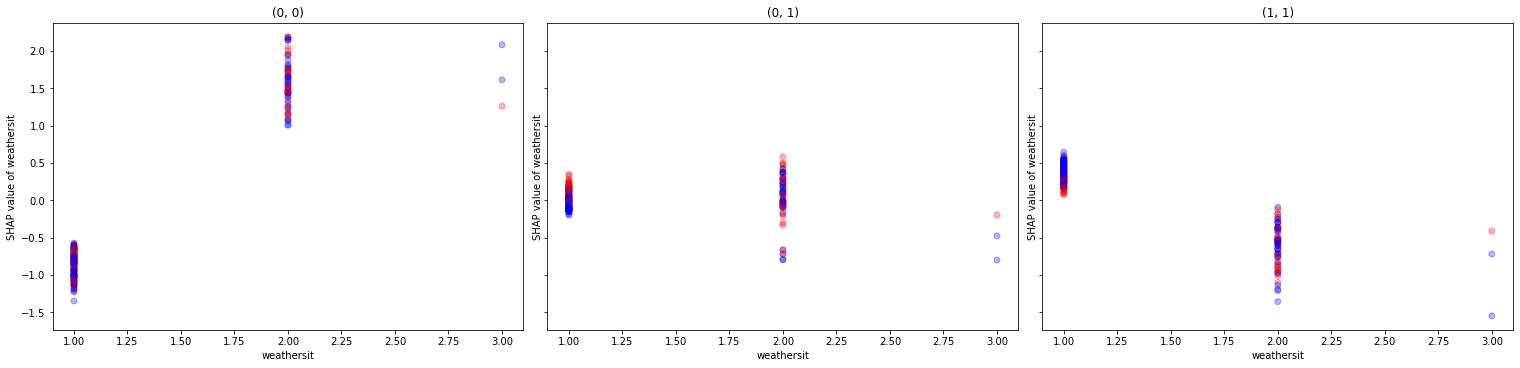

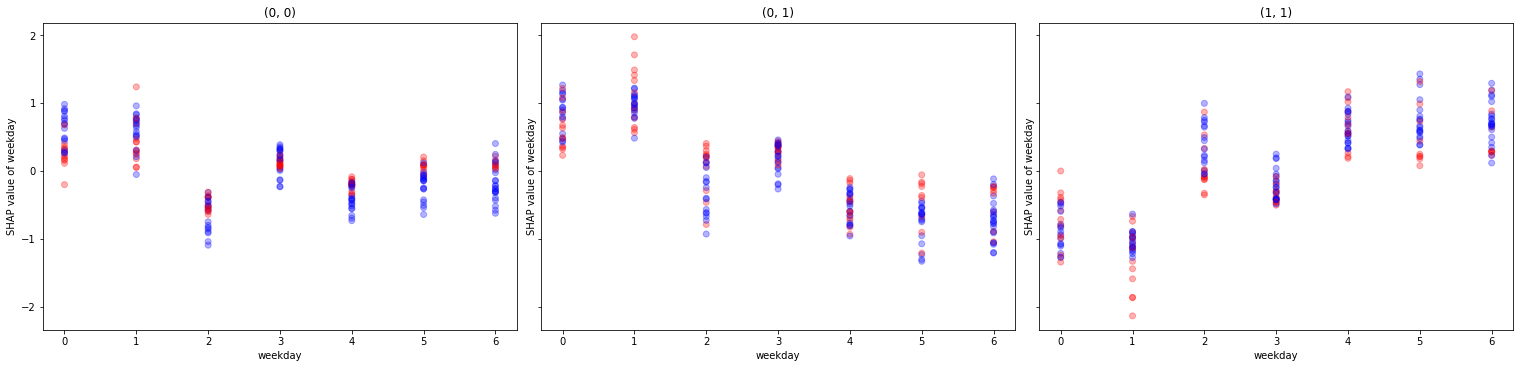

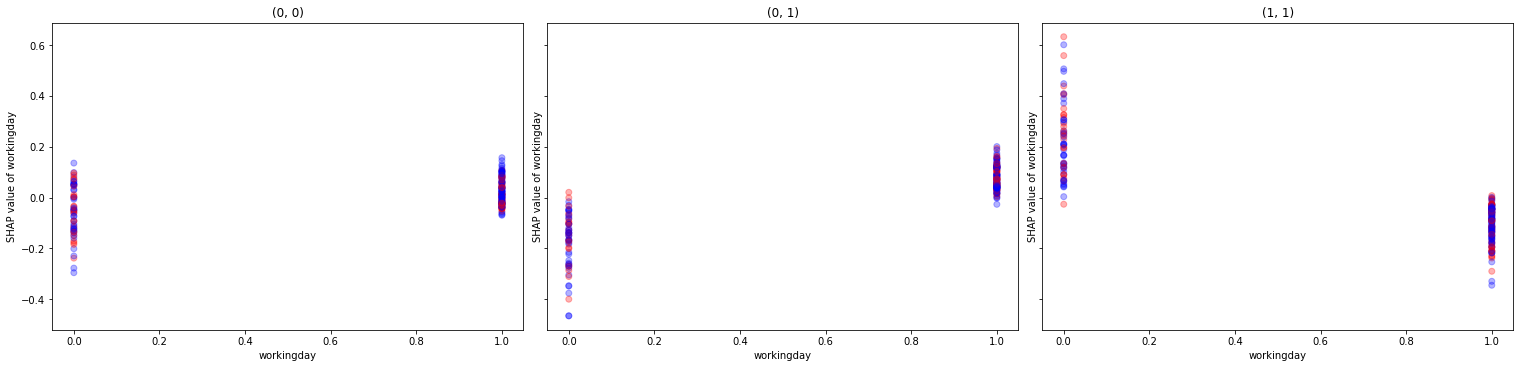

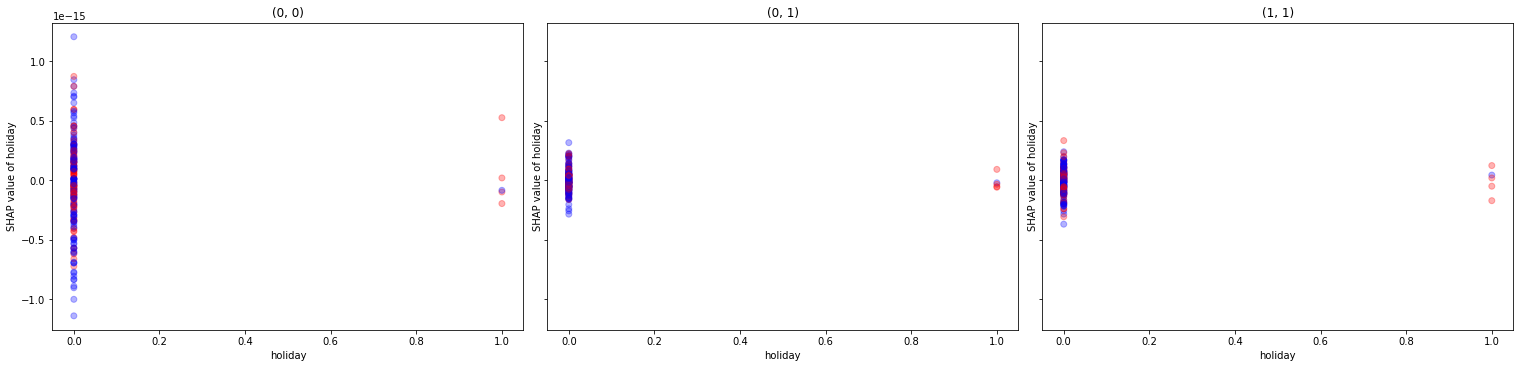

In [59]:
for feature in feature_order:
    clustering.plot_feature(feature, alpha=0.3)

In [67]:
clustering.test(temp=0.7, hum=0.4, mnth=6, season=3, atemp=0.65)

before  after
(0, 1)    79.0    NaN
(1, 1)     NaN   79.0

Counterfactuals:
- $temp=0.3, mnth=1, season=1, atemp=0.24 \rightarrow (0,0)$
- $temp=0.7, hum=0.4, mnth=6, season=3, atemp=0.65 \rightarrow (1,1)$

In [46]:
for feature in global_feature_order:
    print(comparer.feature_names[feature])
    display(clustering.describe_feature(feature))

temp


global   local-all  local-diff
count  366.000000  205.000000   79.000000
mean     0.504081    0.638545    0.636962
std      0.176112    0.097012    0.123561
min      0.107500    0.435833    0.435833
25%      0.347708    0.561667    0.528750
50%      0.514167    0.635833    0.608333
75%      0.653959    0.717500    0.757916
max      0.861667    0.861667    0.861667

mnth


global   local-all  local-diff
count  366.000000  205.000000   79.000000
mean     6.513661    6.843902    6.000000
std      3.455958    2.140878    2.375084
min      1.000000    2.000000    2.000000
25%      4.000000    5.000000    4.000000
50%      7.000000    7.000000    6.000000
75%      9.750000    9.000000    7.500000
max     12.000000   12.000000   12.000000

season


global   local-all  local-diff
count  366.000000  205.000000   79.000000
mean     2.494536    2.712195    2.481013
std      1.112185    0.779704    0.845209
min      1.000000    1.000000    1.000000
25%      2.000000    2.000000    2.000000
50%      2.500000    3.000000    3.000000
75%      3.000000    3.000000    3.000000
max      4.000000    4.000000    4.000000

hum


global   local-all  local-diff
count  366.000000  205.000000   79.000000
mean     0.612166    0.633726    0.638792
std      0.134206    0.122607    0.132994
min      0.254167    0.275833    0.275833
25%      0.508125    0.545417    0.556875
50%      0.611875    0.635833    0.652500
75%      0.711146    0.722917    0.728541
max      0.925000    0.925000    0.925000

windspeed


global   local-all  local-diff
count  366.000000  205.000000   79.000000
mean     0.189572    0.177883    0.201772
std      0.078194    0.069370    0.073016
min      0.046650    0.064071    0.065929
25%      0.133721    0.129354    0.148006
50%      0.174750    0.165417    0.194029
75%      0.231196    0.223258    0.237881
max      0.441563    0.441563    0.441563

weathersit


global   local-all  local-diff
count  366.000000  205.000000   79.000000
mean     1.368852    1.326829    1.367089
std      0.516057    0.500502    0.510837
min      1.000000    1.000000    1.000000
25%      1.000000    1.000000    1.000000
50%      1.000000    1.000000    1.000000
75%      2.000000    2.000000    2.000000
max      3.000000    3.000000    3.000000

atemp


global   local-all  local-diff
count  366.000000  205.000000   79.000000
mean     0.481852    0.600391    0.605033
std      0.156756    0.084303    0.106406
min      0.101658    0.242400    0.435575
25%      0.350685    0.539150    0.515454
50%      0.497779    0.595975    0.577021
75%      0.607646    0.661629    0.709615
max      0.804913    0.804913    0.804913

weekday


global   local-all  local-diff
count  366.000000  205.000000   79.000000
mean     2.986339    3.004878    2.759494
std      2.006108    1.981526    1.922973
min      0.000000    0.000000    0.000000
25%      1.000000    1.000000    1.000000
50%      3.000000    3.000000    3.000000
75%      5.000000    5.000000    4.000000
max      6.000000    6.000000    6.000000

workingday


global   local-all  local-diff
count  366.000000  205.000000   79.000000
mean     0.683060    0.697561    0.696203
std      0.465921    0.460439    0.462835
min      0.000000    0.000000    0.000000
25%      0.000000    0.000000    0.000000
50%      1.000000    1.000000    1.000000
75%      1.000000    1.000000    1.000000
max      1.000000    1.000000    1.000000

holiday


global   local-all  local-diff
count  366.000000  205.000000   79.000000
mean     0.030055    0.024390    0.050633
std      0.170971    0.154635    0.220648
min      0.000000    0.000000    0.000000
25%      0.000000    0.000000    0.000000
50%      0.000000    0.000000    0.000000
75%      0.000000    0.000000    0.000000
max      1.000000    1.000000    1.000000

## Clustering of Class $(1,0)$ SHAP Values

In [82]:
clustering = make_clustering(comparer, explanations.mclass_diff.log_odds, '(1, 0)', '(0, 0)', '(1, 1)')

node #730 (level 0)
(0, 1)    145
(1, 1)    121
(0, 0)     98
(1, 0)      2
dtype: int64


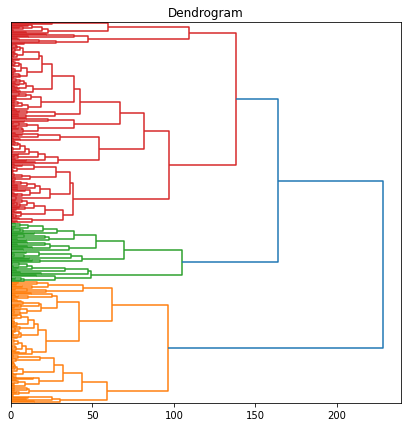

In [83]:
clustering.plot_dendrogram()

### Cluster 1

In [84]:
clustering.go_down()

node #724 (level 1)
(0, 0)    82
(0, 1)    31
(1, 1)     2
(1, 0)     2
dtype: int64


Cluster characteristics:
- $temp < 0.42$
- $atemp < 0.42$

Differences:
- $0.32 < temp < 0.37$
- $mnth = 11$
- $season=4$
- $0.58 < hum < 0.63$
- $0.15 < windspeed < 0.16$
- $weathersit=2$
- $0.32 < atemp < 0.37$
- $weekday=4$
- $workingday=1$ (not relevant)

Counterfactuals:
- $season=1 \rightarrow (0,0)$
- $temp=0.5 \rightarrow (1,1)$

In [85]:
for feature in global_feature_order:
    print(comparer.feature_names[feature])
    display(clustering.describe_feature(feature))

temp


global   local-all  local-diff
count  366.000000  117.000000    2.000000
mean     0.504081    0.300200    0.343750
std      0.176112    0.062647    0.031230
min      0.107500    0.107500    0.321667
25%      0.347708    0.265833    0.332708
50%      0.514167    0.298333    0.343750
75%      0.653959    0.345000    0.354792
max      0.861667    0.415833    0.365833

mnth


global   local-all  local-diff
count  366.000000  117.000000         2.0
mean     6.513661    6.358974        11.0
std      3.455958    4.912092         0.0
min      1.000000    1.000000        11.0
25%      4.000000    2.000000        11.0
50%      7.000000    3.000000        11.0
75%      9.750000   11.000000        11.0
max     12.000000   12.000000        11.0

season


global   local-all  local-diff
count  366.000000  117.000000         2.0
mean     2.494536    2.179487         4.0
std      1.112185    1.471660         0.0
min      1.000000    1.000000         4.0
25%      2.000000    1.000000         4.0
50%      2.500000    1.000000         4.0
75%      3.000000    4.000000         4.0
max      4.000000    4.000000         4.0

hum


global   local-all  local-diff
count  366.000000  117.000000    2.000000
mean     0.612166    0.592443    0.601042
std      0.134206    0.133557    0.027400
min      0.254167    0.311250    0.581667
25%      0.508125    0.497500    0.591355
50%      0.611875    0.567083    0.601042
75%      0.711146    0.687917    0.610730
max      0.925000    0.911250    0.620417

windspeed


global   local-all  local-diff
count  366.000000  117.000000    2.000000
mean     0.189572    0.199114    0.155167
std      0.078194    0.085439    0.003082
min      0.046650    0.046650    0.152987
25%      0.133721    0.144904    0.154077
50%      0.174750    0.184700    0.155167
75%      0.231196    0.231358    0.156256
max      0.441563    0.421642    0.157346

weathersit


global   local-all  local-diff
count  366.000000  117.000000         2.0
mean     1.368852    1.444444         2.0
std      0.516057    0.532471         0.0
min      1.000000    1.000000         2.0
25%      1.000000    1.000000         2.0
50%      1.000000    1.000000         2.0
75%      2.000000    2.000000         2.0
max      3.000000    3.000000         2.0

atemp


global   local-all  local-diff
count  366.000000  117.000000    2.000000
mean     0.481852    0.299737    0.347217
std      0.156756    0.065068    0.032138
min      0.101658    0.101658    0.324492
25%      0.350685    0.258900    0.335855
50%      0.497779    0.301767    0.347217
75%      0.607646    0.350371    0.358579
max      0.804913    0.419813    0.369942

weekday


global   local-all  local-diff
count  366.000000  117.000000         2.0
mean     2.986339    3.008547         4.0
std      2.006108    2.053155         0.0
min      0.000000    0.000000         4.0
25%      1.000000    1.000000         4.0
50%      3.000000    3.000000         4.0
75%      5.000000    5.000000         4.0
max      6.000000    6.000000         4.0

workingday


global   local-all  local-diff
count  366.000000  117.000000         2.0
mean     0.683060    0.641026         1.0
std      0.465921    0.481763         0.0
min      0.000000    0.000000         1.0
25%      0.000000    0.000000         1.0
50%      1.000000    1.000000         1.0
75%      1.000000    1.000000         1.0
max      1.000000    1.000000         1.0

holiday


global   local-all  local-diff
count  366.000000  117.000000         2.0
mean     0.030055    0.051282         0.0
std      0.170971    0.221521         0.0
min      0.000000    0.000000         0.0
25%      0.000000    0.000000         0.0
50%      0.000000    0.000000         0.0
75%      0.000000    0.000000         0.0
max      1.000000    1.000000         0.0

In [88]:
clustering.test(temp=0.5)

before  after
(1, 0)     2.0    NaN
(1, 1)     NaN    2.0

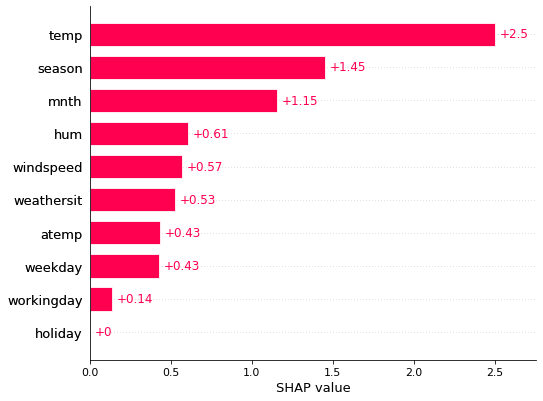

In [89]:
feature_order, feature_importances = calc_feature_order(clustering.shap_values[:, :, clustering.classes])
plot_feature_importance_bar(feature_importances)

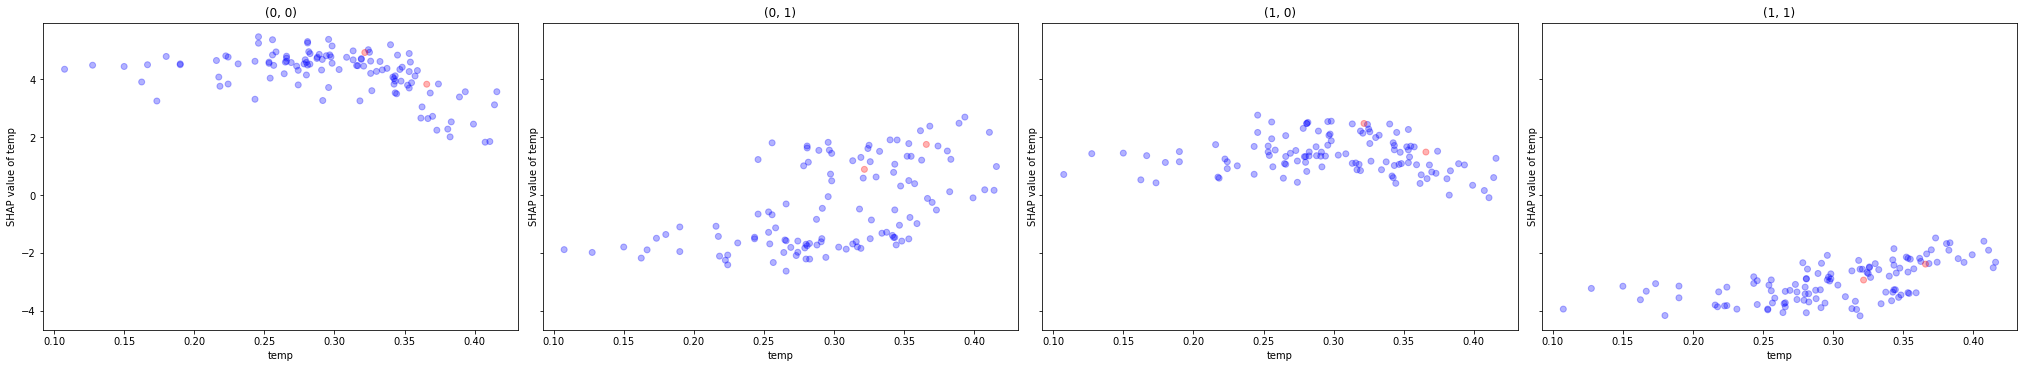

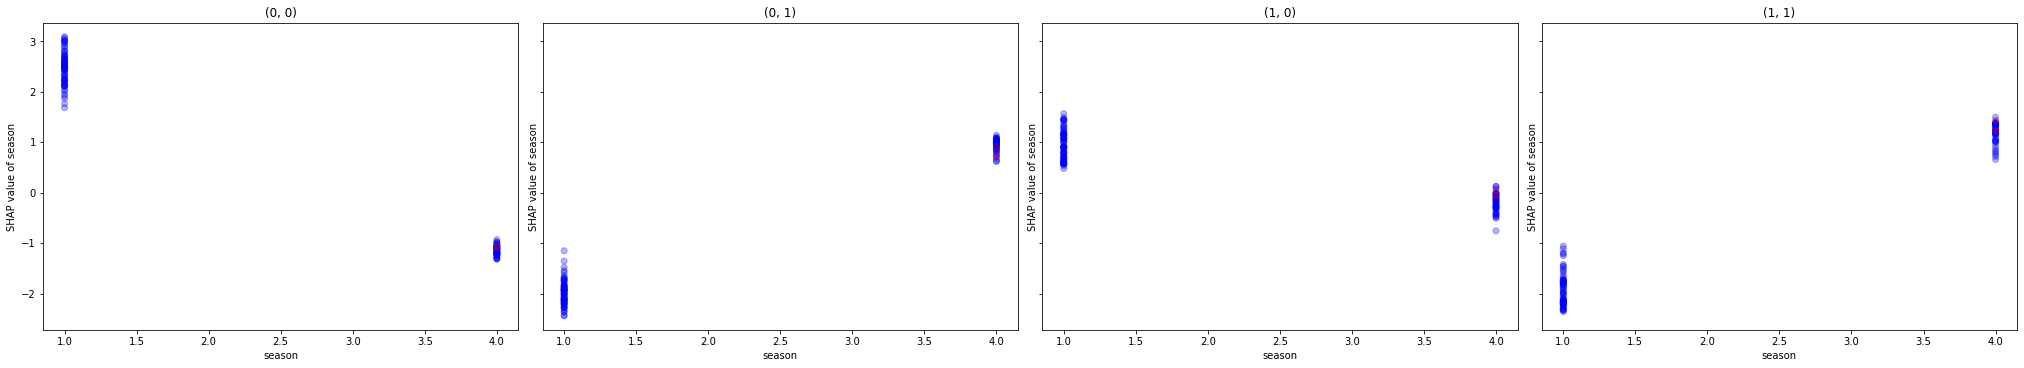

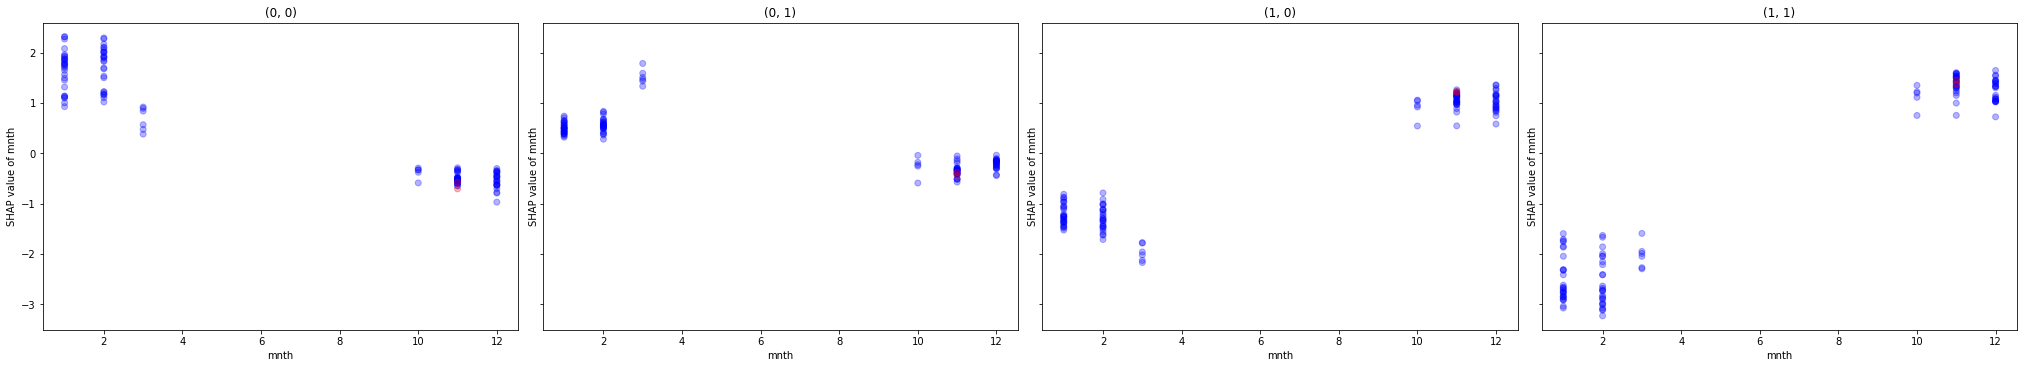

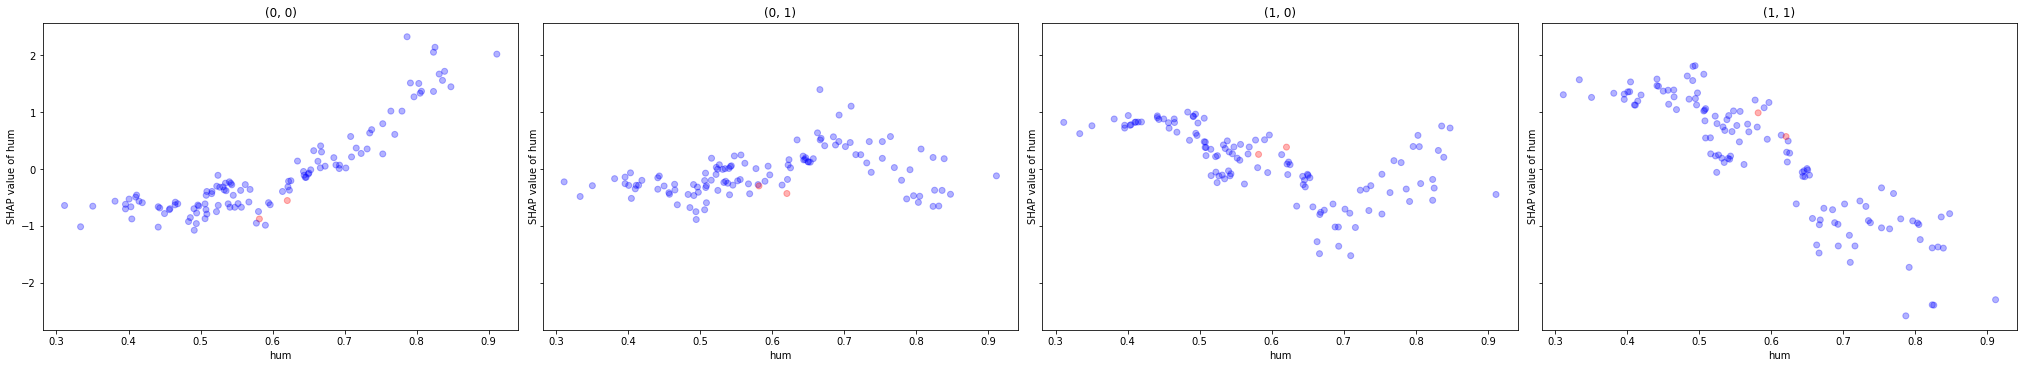

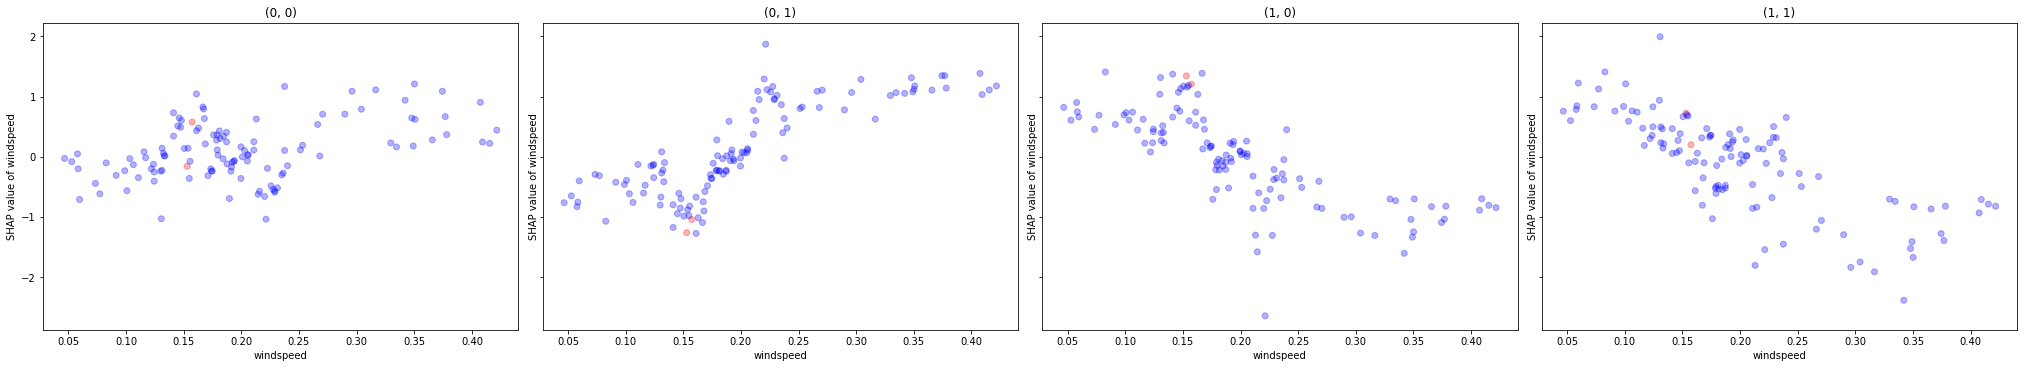

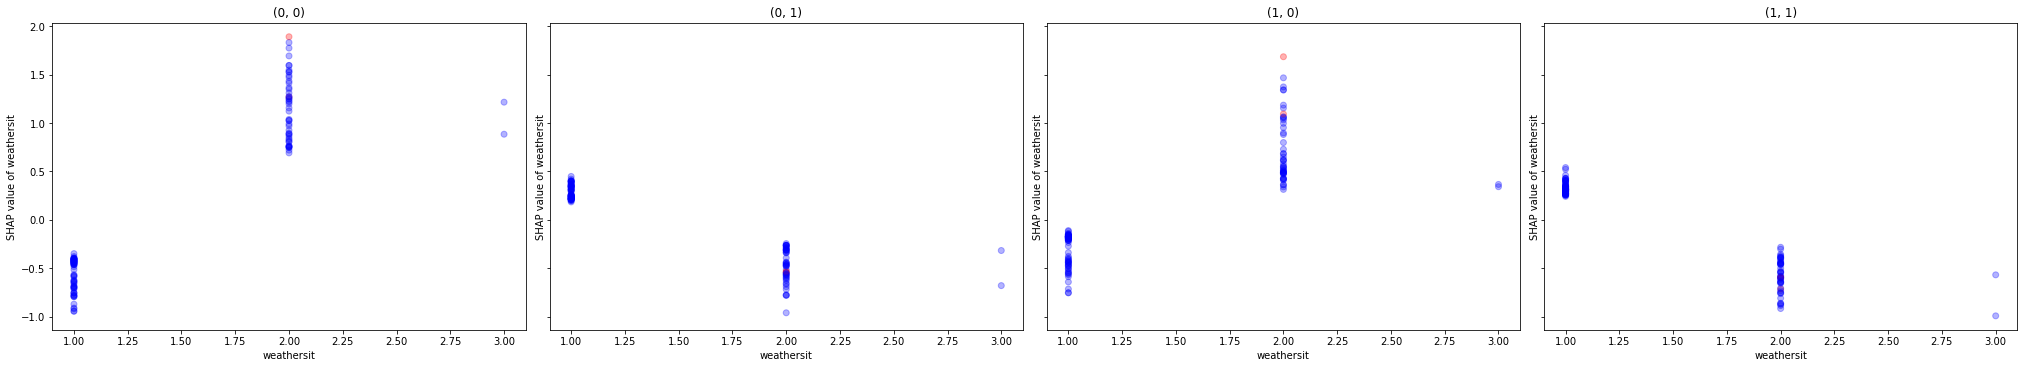

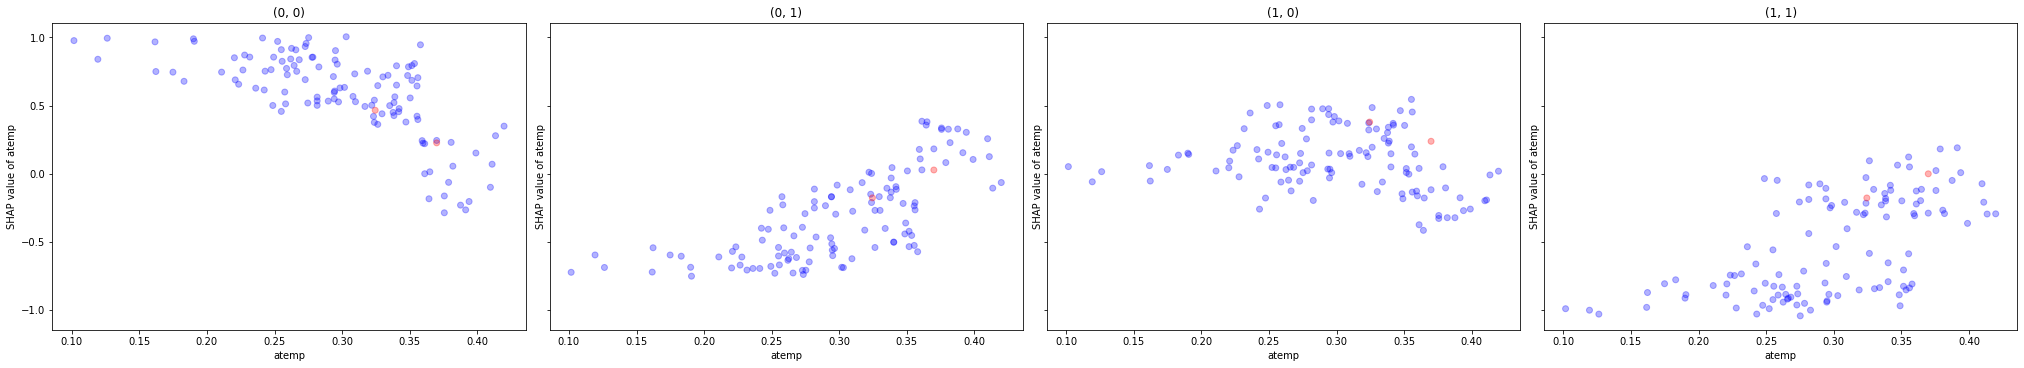

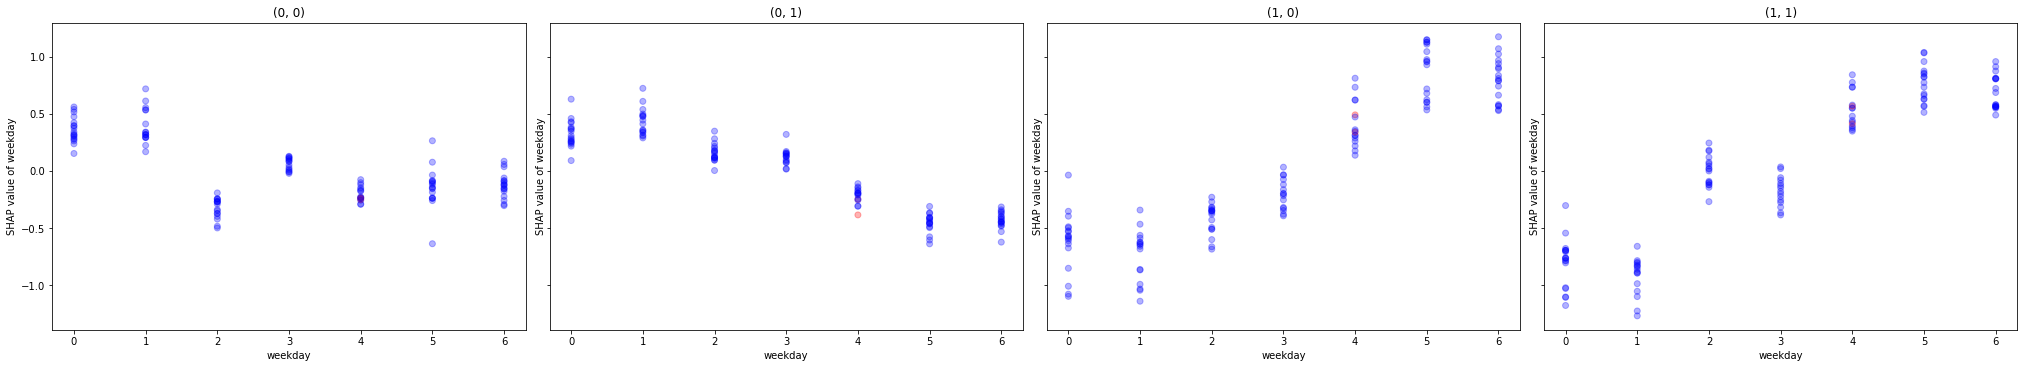

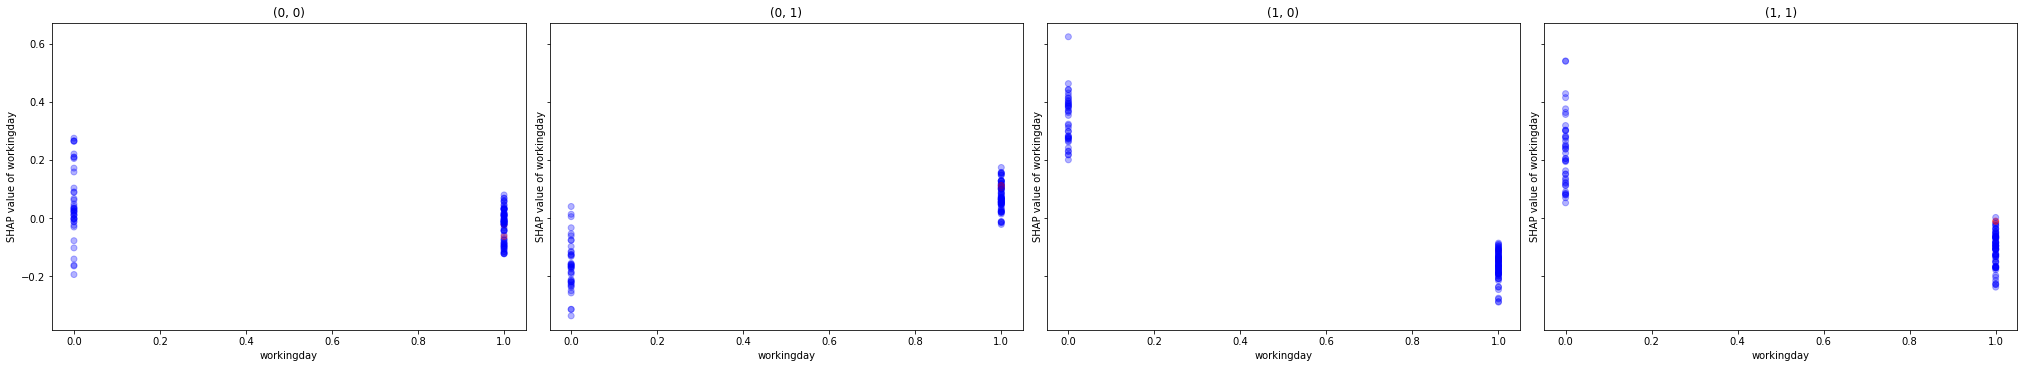

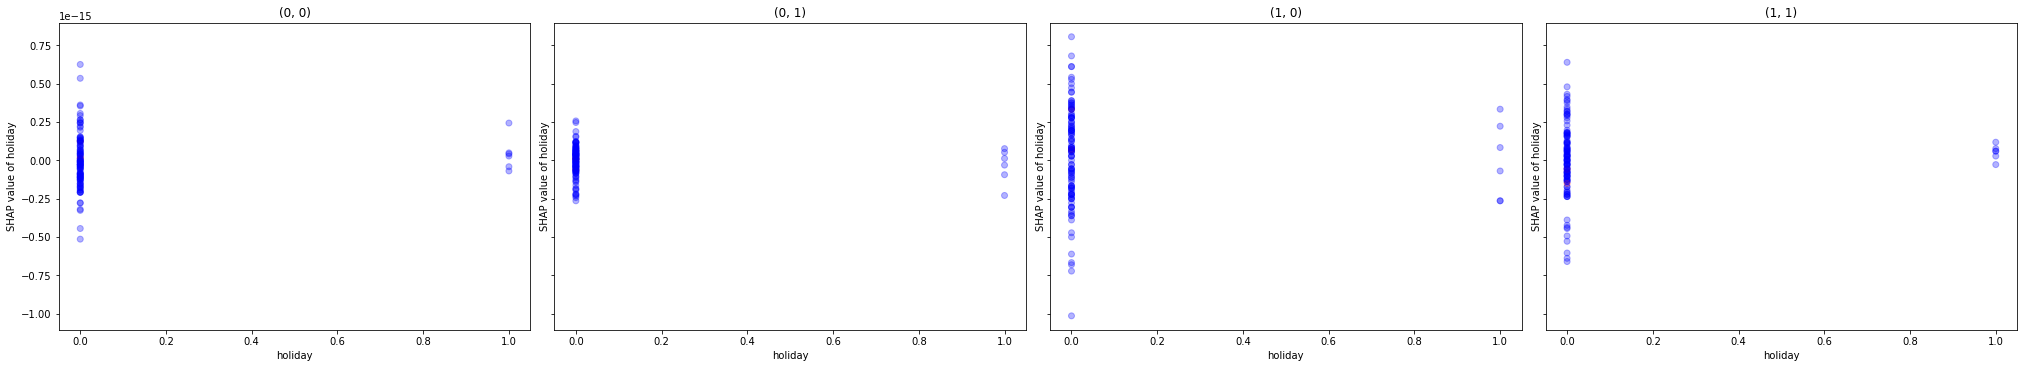

In [90]:
for feature in feature_order:
    clustering.plot_feature(feature, alpha=0.3)

In [93]:
clustering.test(season=1)

before  after
(0, 0)     NaN    2.0
(1, 0)     2.0    NaN